### Setup 

This is just the basic stuff to get things to work

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from chainedMorpher import *

cpu


In [2]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

In [3]:
class simple_MLP_onelayer(torch.nn.Module):
    def __init__(self,in_data,input_size,out_channels=1,act_out=False,nhidden=64,batchnorm=False,batch_size=250,n_epochs=35):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.loss    = nn.BCELoss()
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.opt     = torch.optim.Adam(self.model.parameters(),lr=0.0002)
        self.dataloader = DataLoader(in_data, batch_size=self.batch_size)#,pin_memory=True)
        
    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x
    
    def training_mse_epoch(self):
        running_loss = 0.0
        updates=0
        for batch_idx, (x, y) in enumerate(self.dataloader):
            self.opt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            x_out = self.forward(x)
            loss  = self.loss(x_out.flatten(), y.flatten())
            loss.backward()
            self.opt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def training_mse(self):
        for epoch in range(self.n_epochs):
            self.model.train(True)
            loss_train = self.training_mse_epoch()
            #self.model2.train(False)
            #loss_valid = self.validate_mse_epoch(self.model2,self.val_dataloader_mse())
            print('Epoch: {} LOSS train: {} '.format(epoch,loss_train))



## Test 1 : A Gaussian that is shifted

Here we take a dataset with 5 dimensions (we have done up to 15), and we just shift one of the dimensions in one of the datasets by 0.5 sigma, then we map one to the other. 

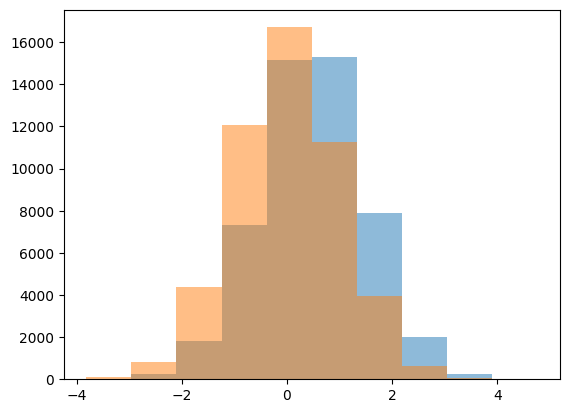

In [4]:
def makeDataSet(iN=50000,iDim=5):
    #1 is going to be called MC
    #2 is going to be called data later on
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,1] += 0.5
    _,bins,_=plt.hist(v1[:,1],alpha=0.5)
    plt.hist(v2[:,1],bins=bins,alpha=0.5)
    plt.show()
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet()

Now we do the reweighting training and teh apply this to a new dataset.

Epoch: 0 LOSS train: 0.5391186475753784 
Epoch: 1 LOSS train: 0.6671472191810608 
Epoch: 2 LOSS train: 0.6360754370689392 
Epoch: 3 LOSS train: 0.6475656032562256 
Epoch: 4 LOSS train: 0.6587235927581787 
Epoch: 5 LOSS train: 0.6672681570053101 
Epoch: 6 LOSS train: 0.6727790236473083 
Epoch: 7 LOSS train: 0.6758697032928467 
Epoch: 8 LOSS train: 0.677257776260376 
Epoch: 9 LOSS train: 0.677676796913147 
Epoch: 10 LOSS train: 0.6775823831558228 
Epoch: 11 LOSS train: 0.6565491557121277 
Epoch: 12 LOSS train: 0.696206271648407 
Epoch: 13 LOSS train: 0.6799376606941223 
Epoch: 14 LOSS train: 0.6776689887046814 
Epoch: 15 LOSS train: 0.6769098043441772 
Epoch: 16 LOSS train: 0.6765559315681458 
Epoch: 17 LOSS train: 0.6762861609458923 
Epoch: 18 LOSS train: 0.6760643124580383 
Epoch: 19 LOSS train: 0.6758484840393066 
Epoch: 20 LOSS train: 0.6756691932678223 
Epoch: 21 LOSS train: 0.6754924058914185 
Epoch: 22 LOSS train: 0.6752992868423462 
Epoch: 23 LOSS train: 0.6751554012298584 
Epoch

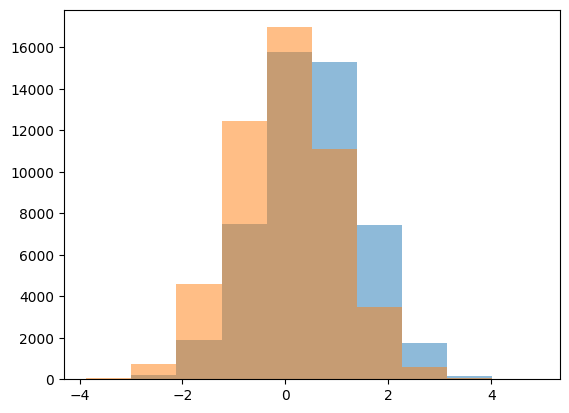

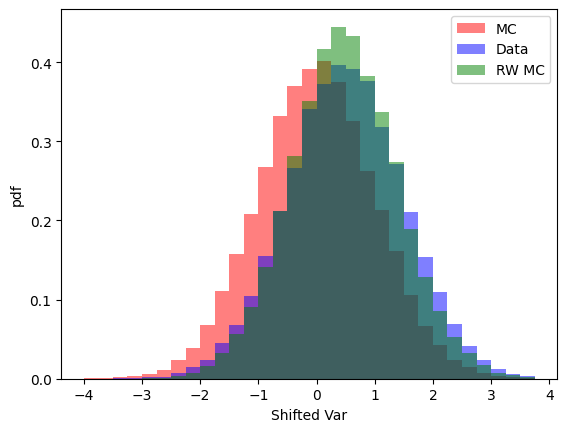

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


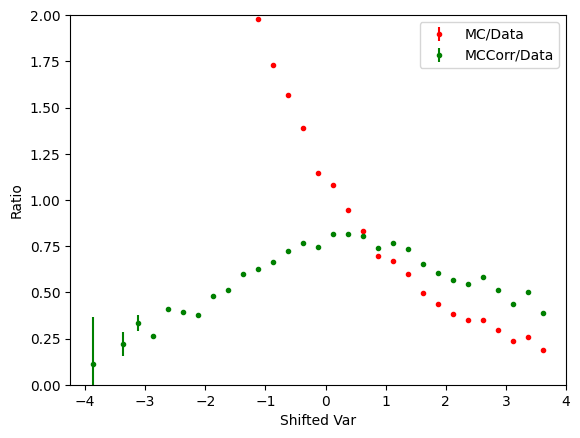

In [16]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()
#
data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()
#plt.hist(weight[label_in==1],alpha=0.5,bins=np.arange(0.75,2,0.05))
#plt.show()
def ratioComp(iData,iMC,iMCCorr,bin_edge):#
    ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
    ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
    bincenter = 0.5 * (bin_edge[1:] + bin_edge[:-1])
    plt.errorbar(bincenter, ratio1, yerr=err1, fmt='.', color='r',label='MC/Data')
    plt.errorbar(bincenter, ratio2, yerr=err2, fmt='.', color='g',label='MCCorr/Data')
    plt.ylim(0,2)
    plt.xlabel('Shifted Var')
    plt.ylabel("Ratio")
    plt.legend()
    plt.ylim(0,2.0)
    plt.show()

def weightedComp(iData,iMC,iWeights):
    val1,_,_       =plt.hist(iMC,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='r',label='MC')
    val2,_,_       =plt.hist(iData,alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='b',label='Data')
    valc,bin_edge,_=plt.hist(iMC,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),weights=iWeights,color='g',label='RW MC')
    plt.xlabel('Shifted Var')
    plt.ylabel("pdf")
    plt.legend()
    plt.show()

    val1*=len(iMC)
    val2*=len(iData)
    valc*=np.sum(iWeights)
    ratioComp(val2,val1,valc,bin_edge)
    
weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])

Now we train the flows for this

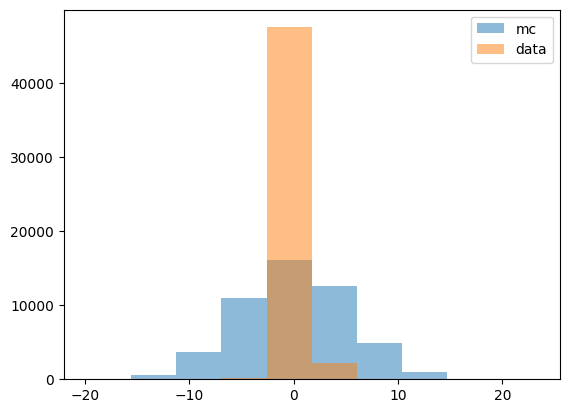

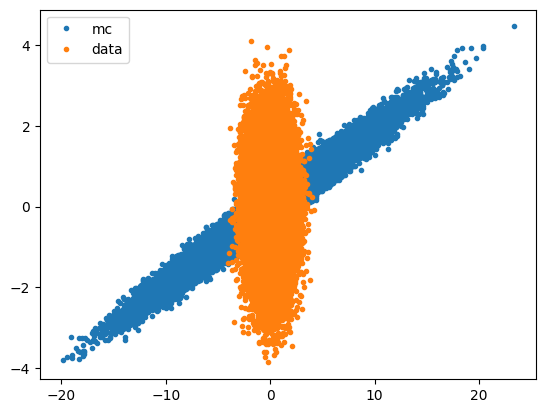

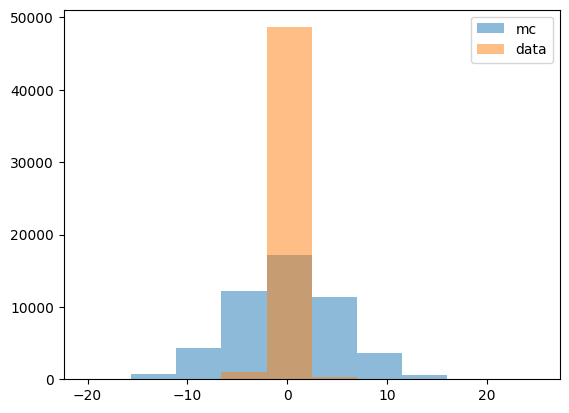

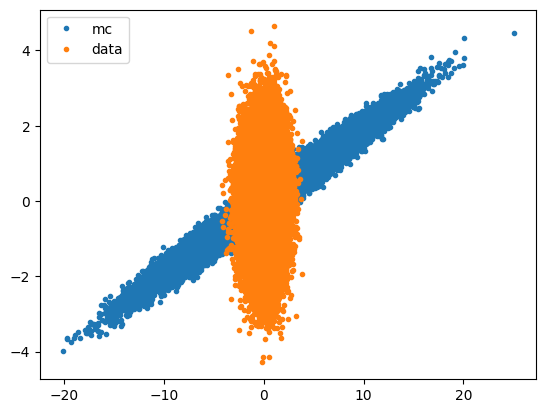

/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.1207587671279908, p = 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.104841091632843, p = 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 1.0715480589866637, p = 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.23it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 1.1203326535224916, p = 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.89it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: 0.005046063736081123, p = 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 1.051080961227417, p = 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: 1.0887353920936584, p = 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.89it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: 1.0155942022800446, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.0859618854522706, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


Loss: 1.0586673974990846, p = 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.51it/s]


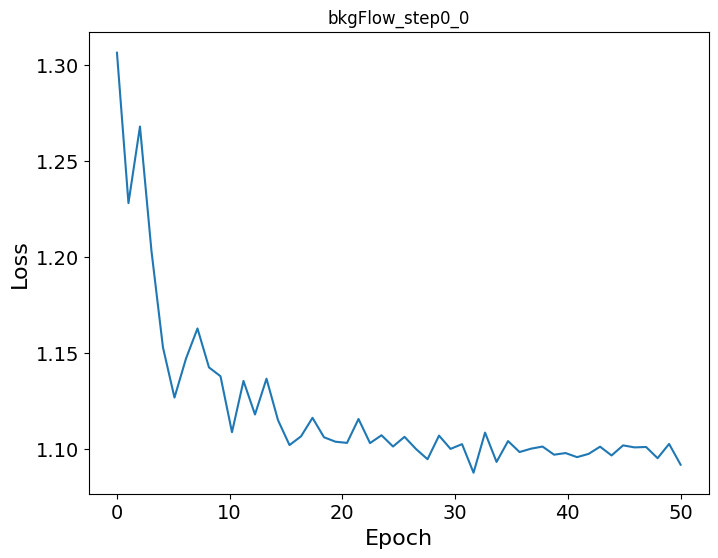

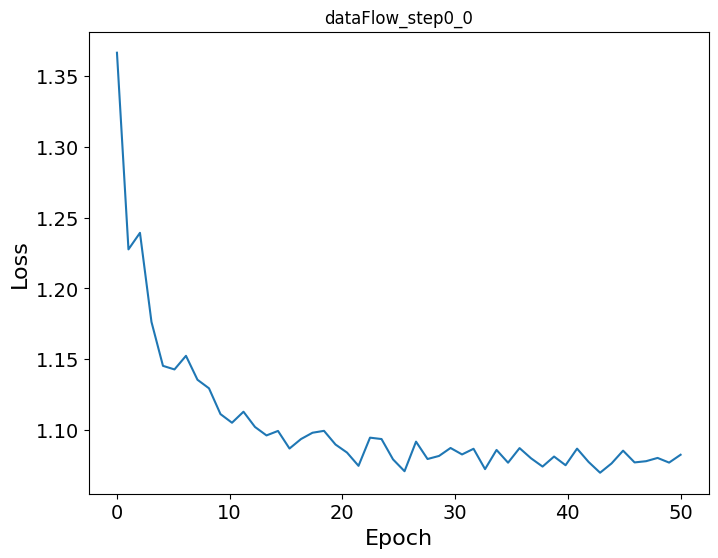

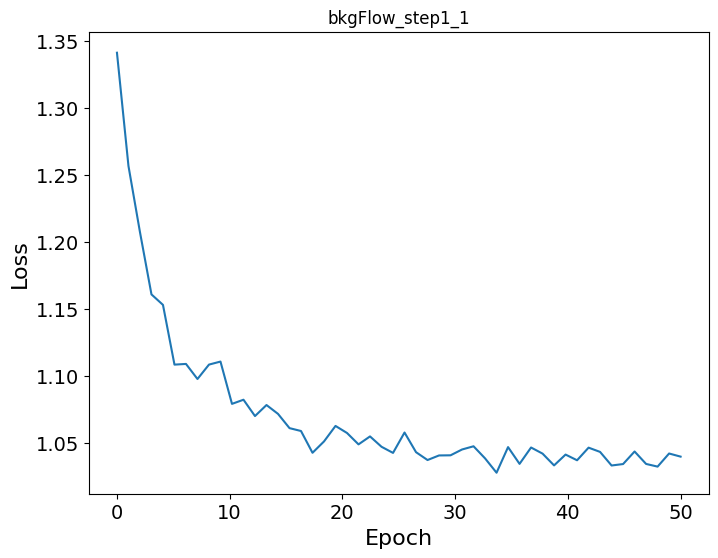

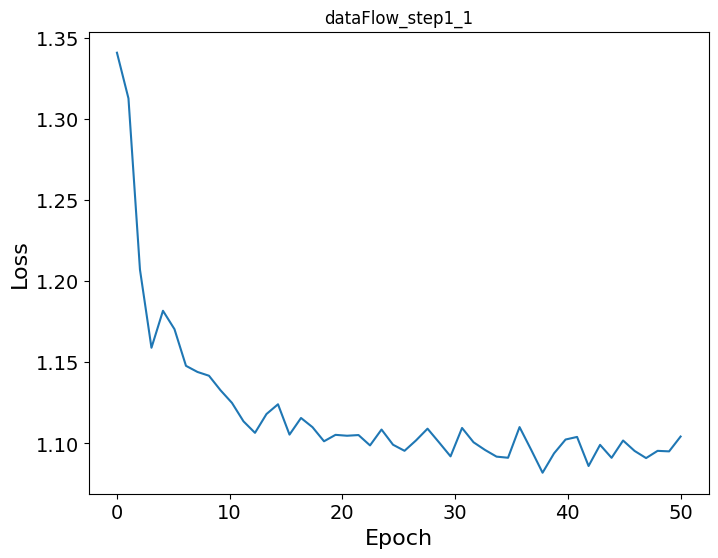

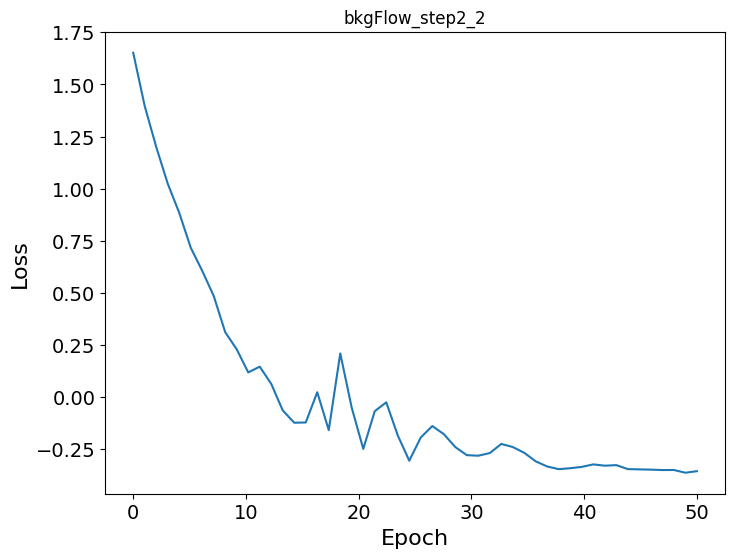

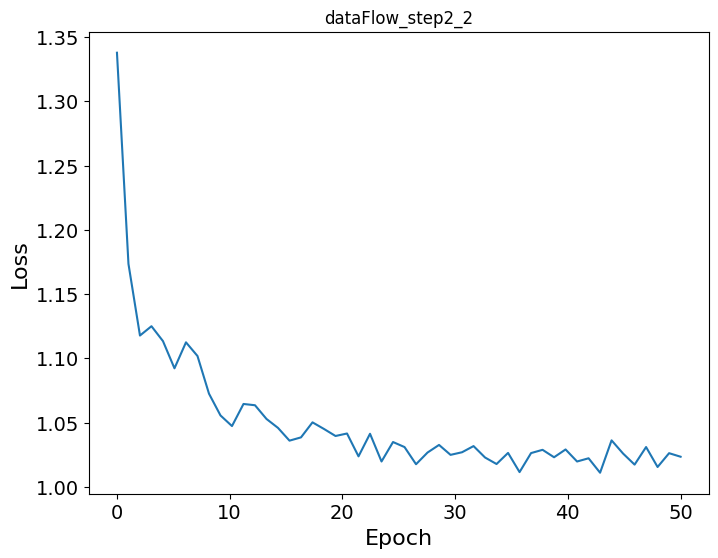

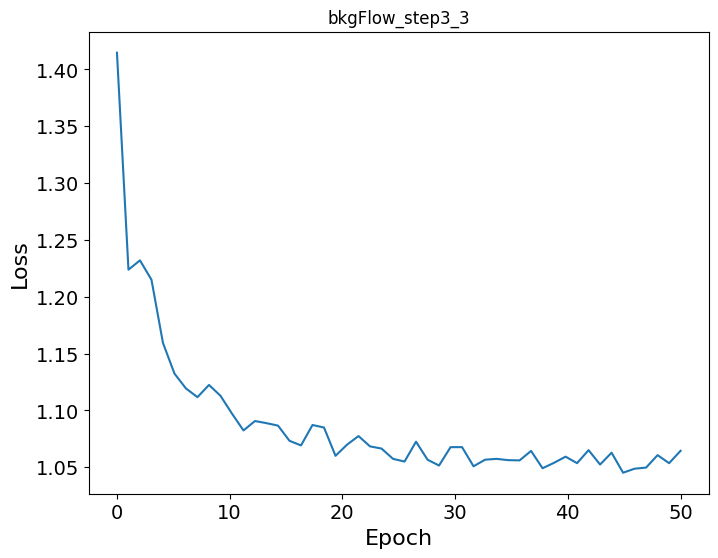

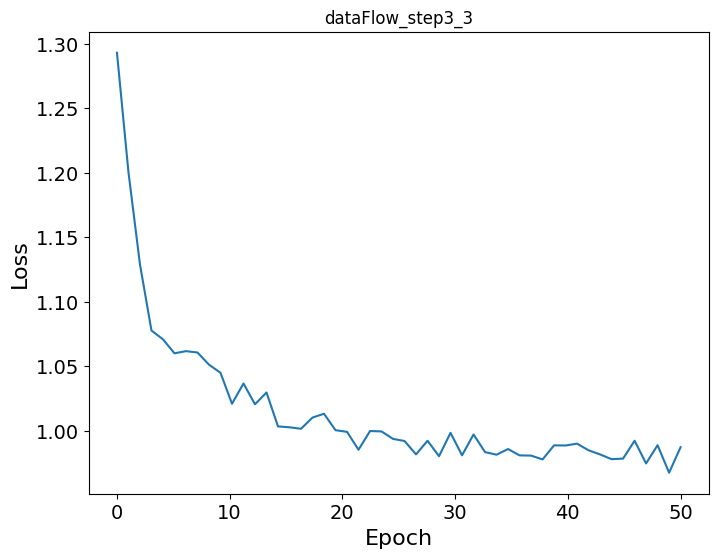

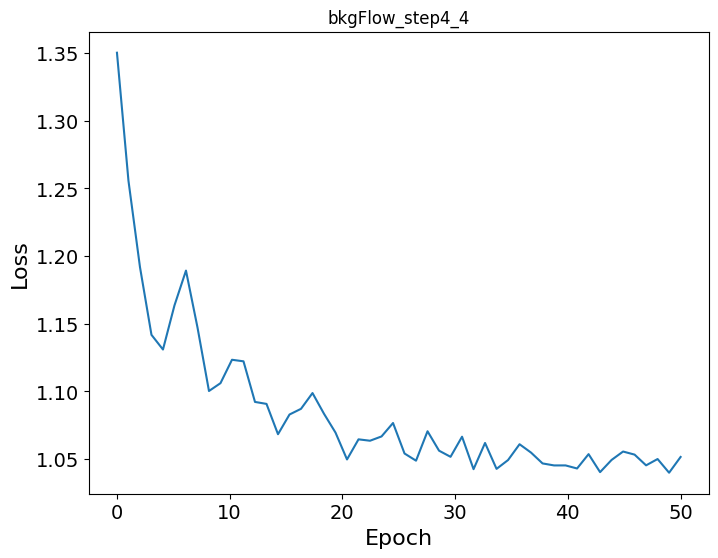

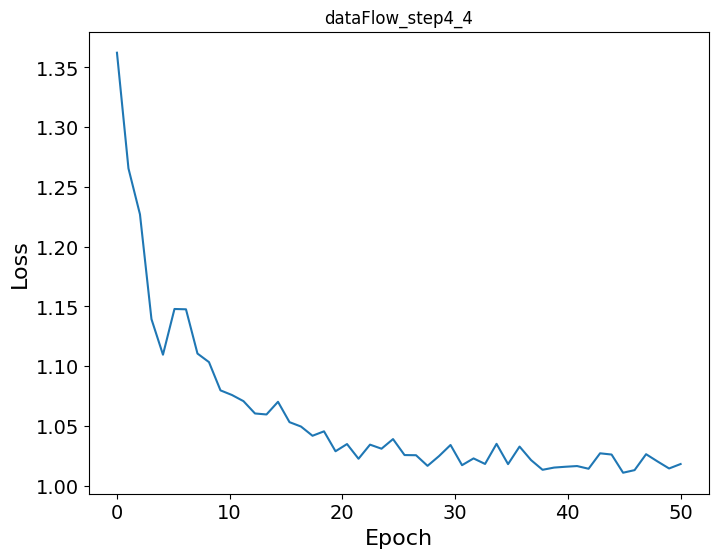

In [25]:
def trainflows(iMC_train,iMC_test,iData_train,iData_test,iNLayers=1):
    NF_kwargs = {"flow_type":"NSRATQUAD","tail_bound":3.2,"hidden_features":150,
                 "num_layers":iNLayers,"num_bins":50,"num_blocks_per_layer":1,"tails":"linear",
                "dropout":0.0,"residual":True}

    dim=5
    fitvars=[]
    for i0 in range(dim):
        fitvars.append(str(i0))
    rangeScale = 3
    variables = fitvars
    trainer = chainedNFTrainer("NAME_FOR_PROJECT",mc_train,mc_test,data_train,data_test,fitvars,control=[],
                                NF_kwargs=NF_kwargs,rangeScale=rangeScale,separateScale=True)
    bs = 10000
    n_epoch = 10
    n_iter = n_epoch*mc_train.shape[0]//bs
    for i0 in range(dim):
        trainer.trainCurrentBkg(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
        #trainer.plotDensity(bkg=True)
        trainer.trainCurrentData(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
        #trainer.plotDensity(data=True)
        trainer.stepForward()
    return trainer
    
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)

Finally we compare the same arios as before, but now with the corrected

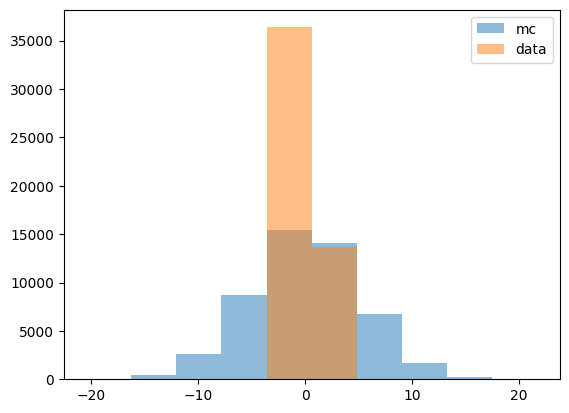

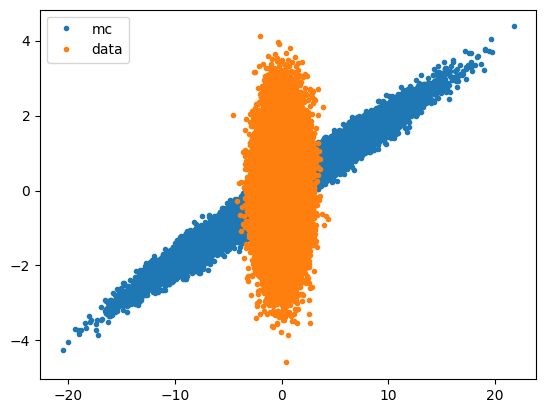

  0%|                                                                                                                                                                       | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.61it/s]


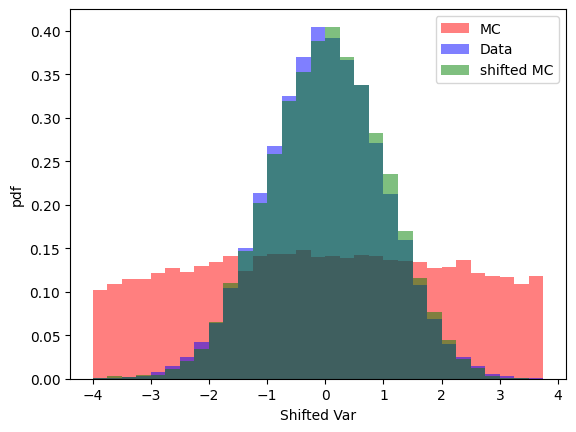

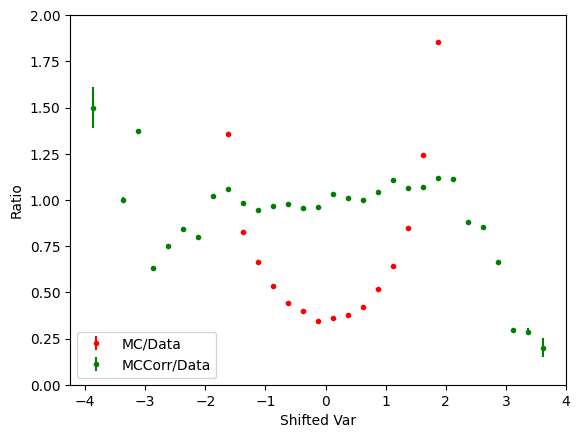

In [26]:
def quantileComp(iData,iMC,iMCCorr):
    val1,_,_       =plt.hist(iMC,    alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='r',label='MC')
    val2,_,_       =plt.hist(iData,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='b',label='Data')
    valc,bin_edge,_=plt.hist(iMCCorr,alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='g',label='shifted MC')
    plt.xlabel('Shifted Var')
    plt.ylabel("pdf")
    plt.legend()
    plt.show()

    val1*=len(iMC)
    val2*=len(iData)
    valc*=len(iMCCorr)
    ratioComp(val2,val1,valc,bin_edge)

alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])



## Test 2 : Adding a strong correlation

Now we are going to take the data and make it such that 

$v_{i} = \mathcal{N}(0,1) \forall i \neq 2$ and 
$v_{2} = \mathcal{N}(0,1) + 5 v_{3}$

This puts a strong correlation in one of the variables, but makes everything else random

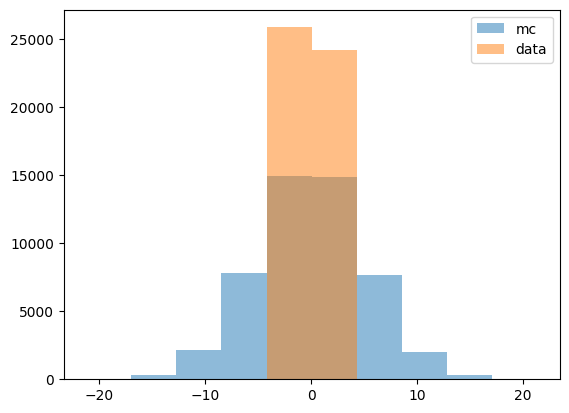

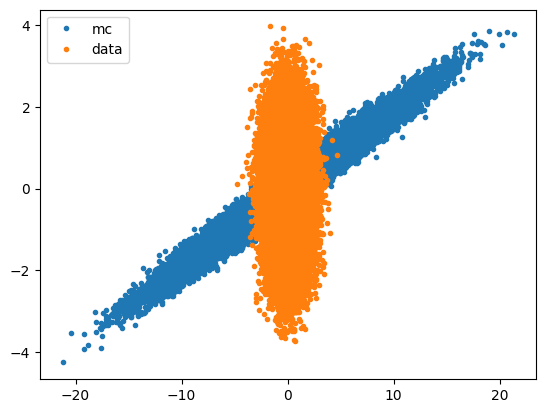

In [27]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,1] += 5.*v1[:,2]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,2],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,2],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Epoch: 0 LOSS train: 0.44517844915390015 
Epoch: 1 LOSS train: 0.6395252346992493 
Epoch: 2 LOSS train: 0.42673301696777344 
Epoch: 3 LOSS train: 0.3685242533683777 
Epoch: 4 LOSS train: 0.33495375514030457 
Epoch: 5 LOSS train: 0.31463557481765747 
Epoch: 6 LOSS train: 0.30035579204559326 
Epoch: 7 LOSS train: 0.2890378534793854 
Epoch: 8 LOSS train: 0.27919501066207886 
Epoch: 9 LOSS train: 0.2700910270214081 
Epoch: 10 LOSS train: 0.2609497606754303 
Epoch: 11 LOSS train: 0.2524630129337311 
Epoch: 12 LOSS train: 0.24476541578769684 
Epoch: 13 LOSS train: 0.2379836142063141 
Epoch: 14 LOSS train: 0.2318982183933258 
Epoch: 15 LOSS train: 0.22659575939178467 
Epoch: 16 LOSS train: 0.2221040576696396 
Epoch: 17 LOSS train: 0.21843761205673218 
Epoch: 18 LOSS train: 0.21560002863407135 
Epoch: 19 LOSS train: 0.21348130702972412 
Epoch: 20 LOSS train: 0.2120250165462494 
Epoch: 21 LOSS train: 0.2111227810382843 
Epoch: 22 LOSS train: 0.21074140071868896 
Epoch: 23 LOSS train: 0.21075576

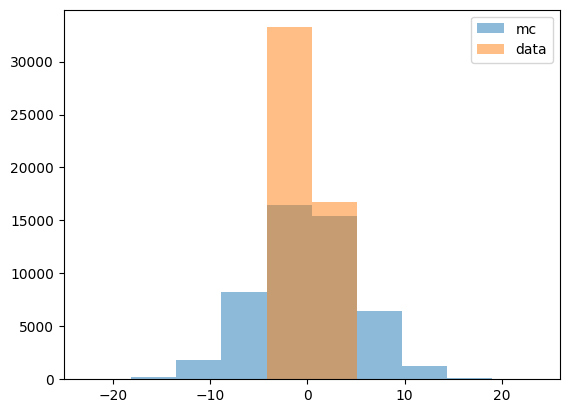

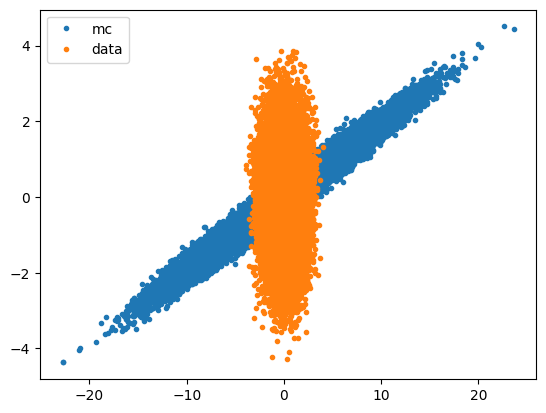

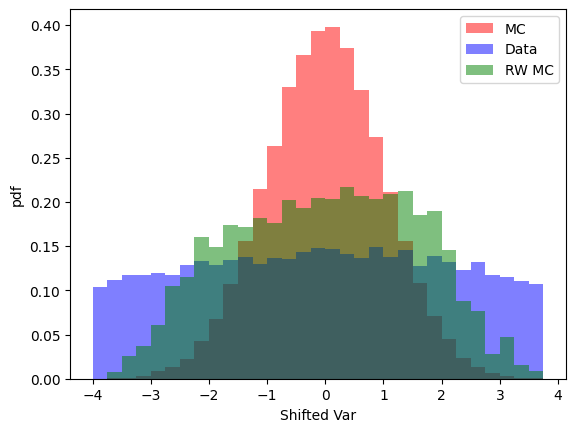

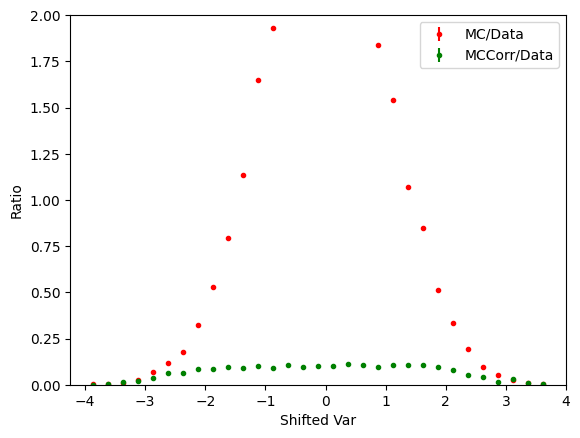

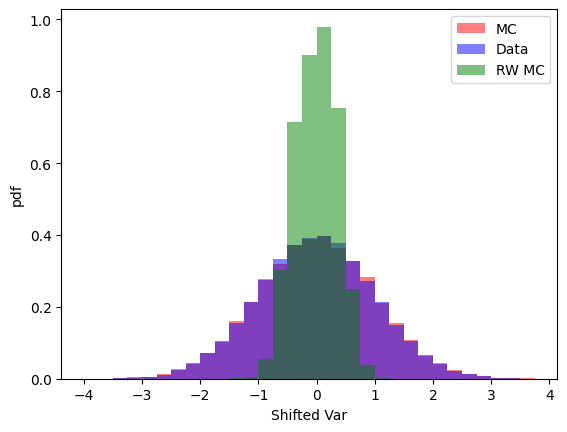

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


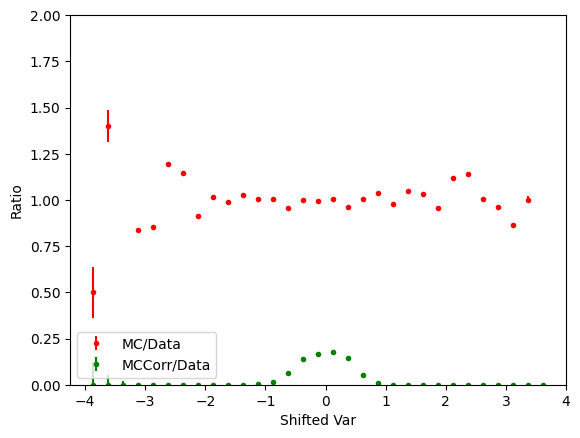

In [22]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
#plt.plot(test_in[:,2][label_in==0],weight[label_in==0],'.')
#plt.show()

/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.0792412185668945, p = 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.0386483836174012, p = 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 1.0477125978469848, p = 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 1.0823884844779967, p = 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.72it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: -0.07735213913023471, p = 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 1.0429024004936218, p = 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: 1.0678395891189576, p = 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.68it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: 1.045221939086914, p = 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.71it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.0598679852485657, p = 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


Loss: 1.0361786782741547, p = 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]


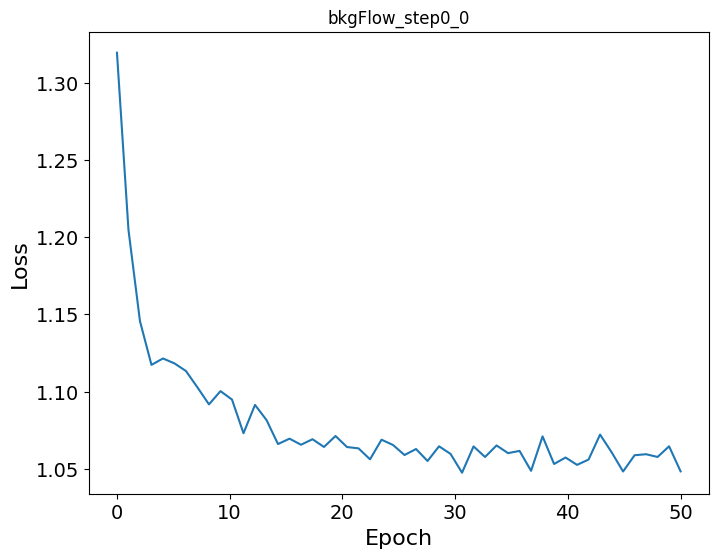

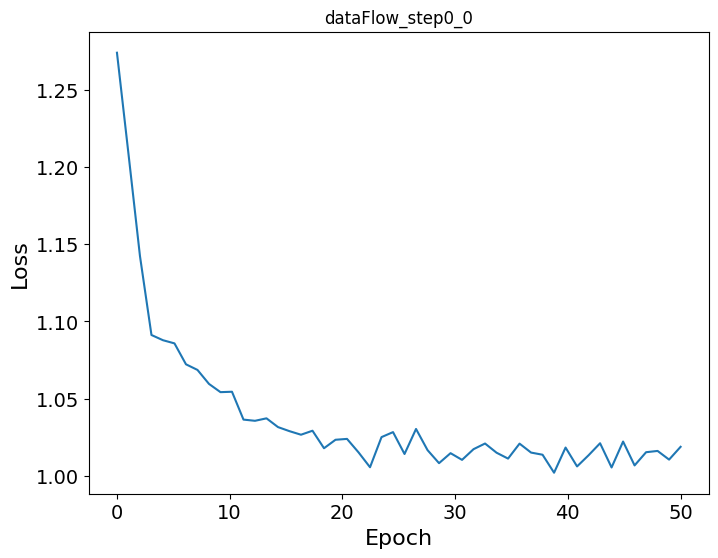

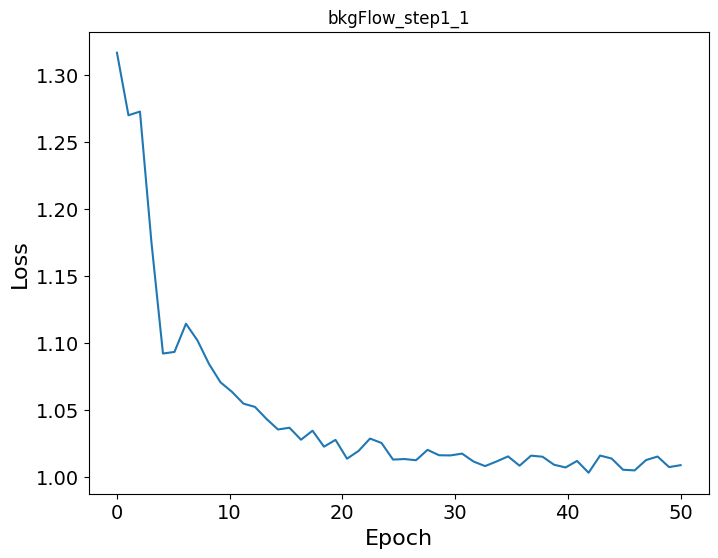

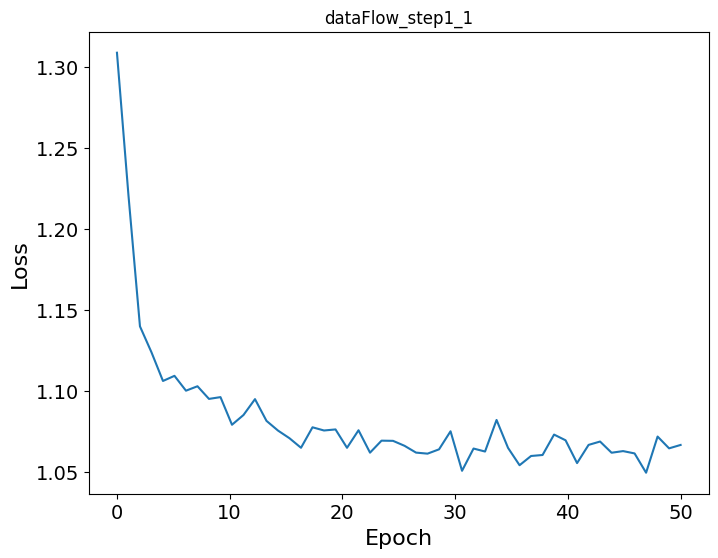

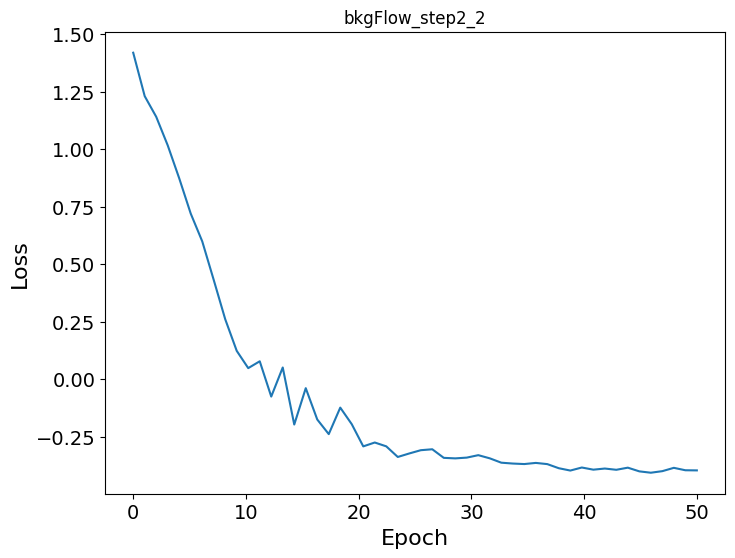

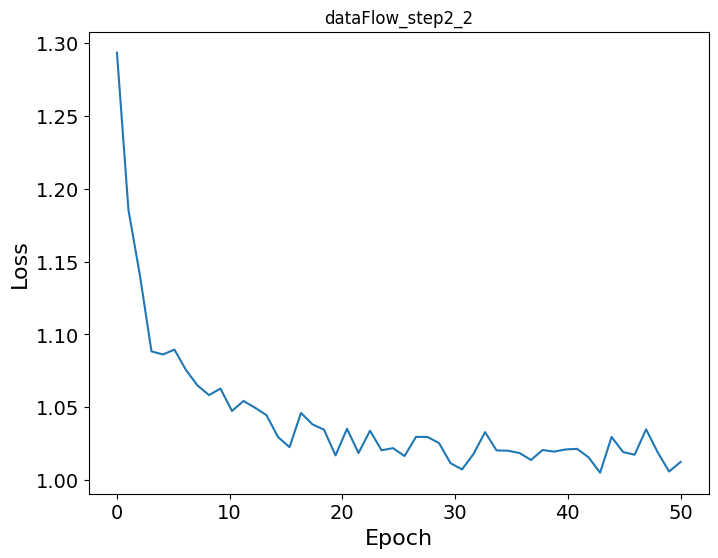

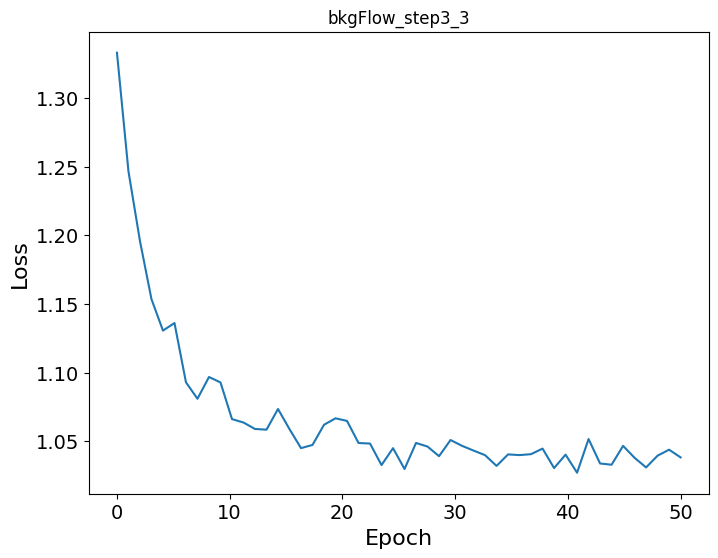

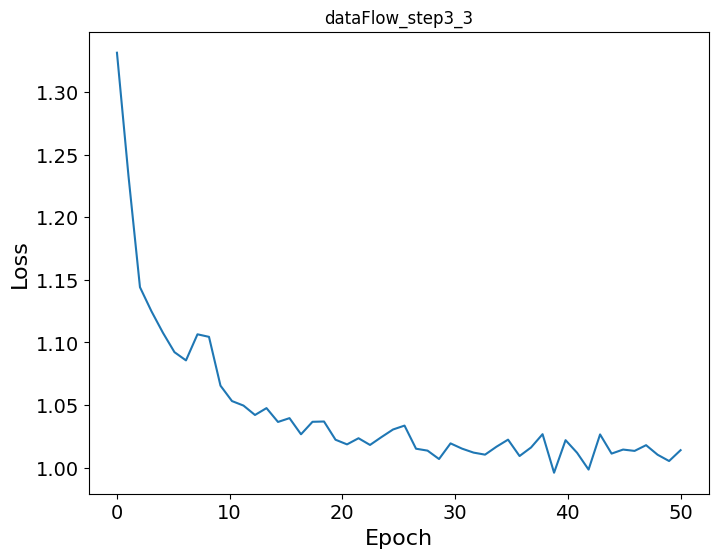

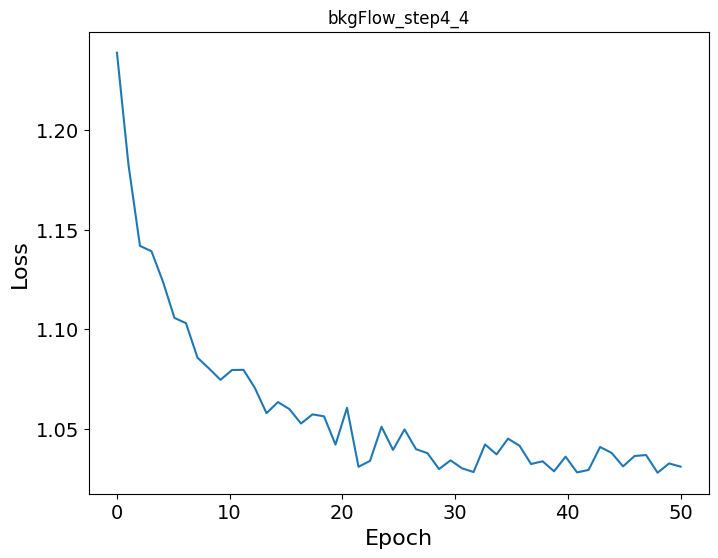

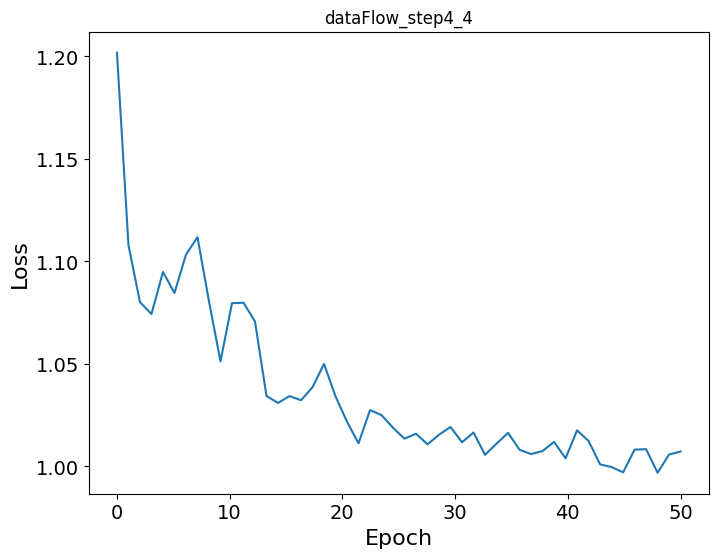

In [28]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.05it/s]


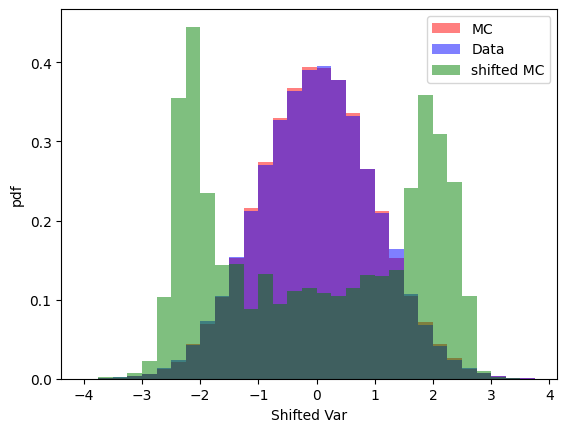

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


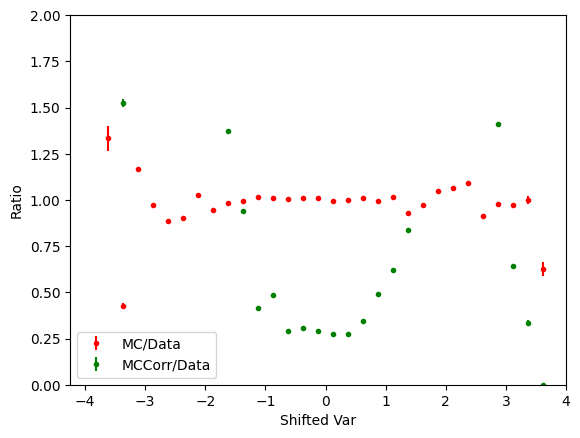

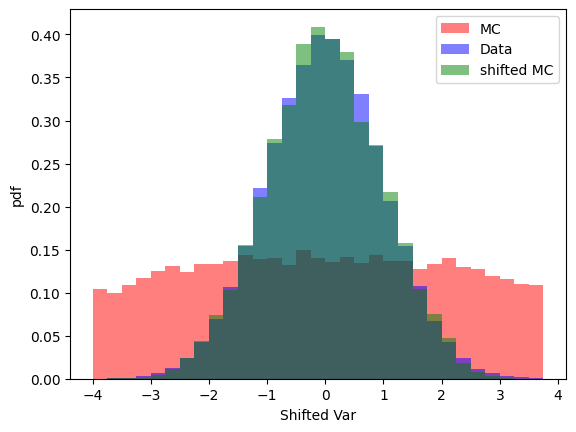

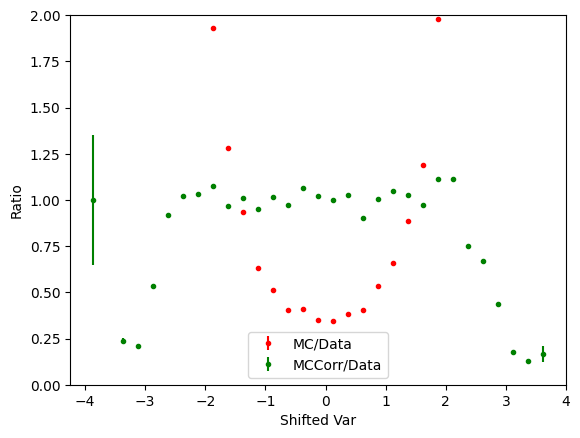

In [30]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])

## Now lets do the same thing as the previous swapping the variables


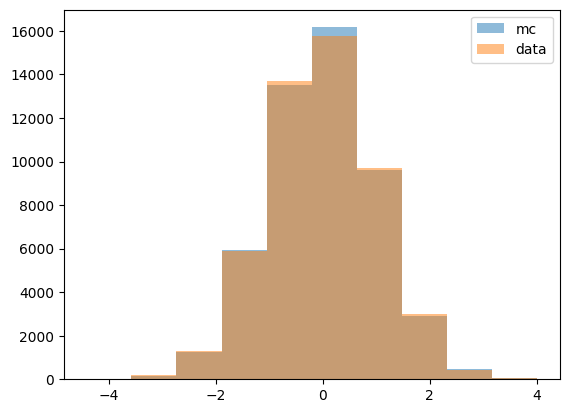

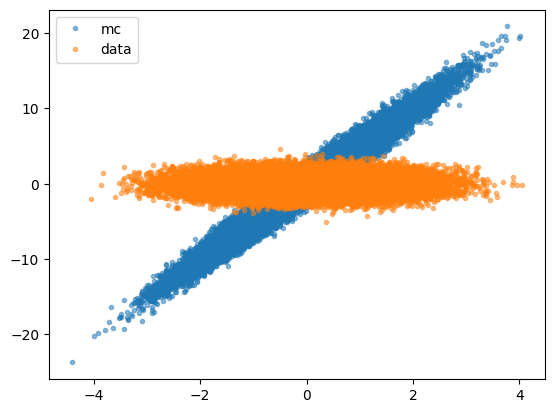

In [32]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,2] += 5.*v1[:,1]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,2],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,2],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Repeat the same as above, reweighting and then quantile

Epoch: 0 LOSS train: 0.4600768983364105 
Epoch: 1 LOSS train: 0.6455960273742676 
Epoch: 2 LOSS train: 0.4138784408569336 
Epoch: 3 LOSS train: 0.3582751750946045 
Epoch: 4 LOSS train: 0.3307190239429474 
Epoch: 5 LOSS train: 0.31221428513526917 
Epoch: 6 LOSS train: 0.2987353205680847 
Epoch: 7 LOSS train: 0.28748875856399536 
Epoch: 8 LOSS train: 0.2776104509830475 
Epoch: 9 LOSS train: 0.2686244249343872 
Epoch: 10 LOSS train: 0.26038825511932373 
Epoch: 11 LOSS train: 0.2528302073478699 
Epoch: 12 LOSS train: 0.24602647125720978 
Epoch: 13 LOSS train: 0.23993737995624542 
Epoch: 14 LOSS train: 0.23461245000362396 
Epoch: 15 LOSS train: 0.2300727814435959 
Epoch: 16 LOSS train: 0.22635063529014587 
Epoch: 17 LOSS train: 0.22334104776382446 
Epoch: 18 LOSS train: 0.22103175520896912 
Epoch: 19 LOSS train: 0.21930815279483795 
Epoch: 20 LOSS train: 0.2181258350610733 
Epoch: 21 LOSS train: 0.21740102767944336 
Epoch: 22 LOSS train: 0.21705541014671326 
Epoch: 23 LOSS train: 0.21700792

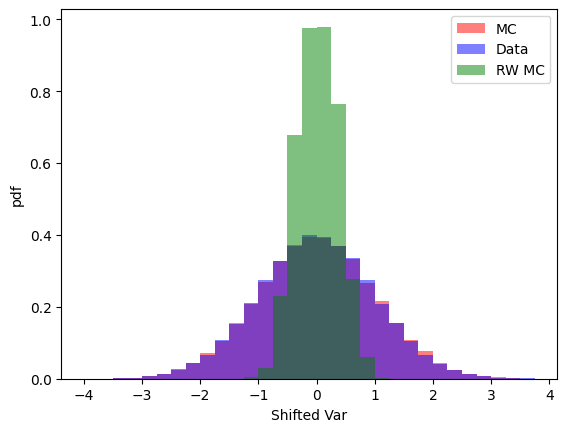

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


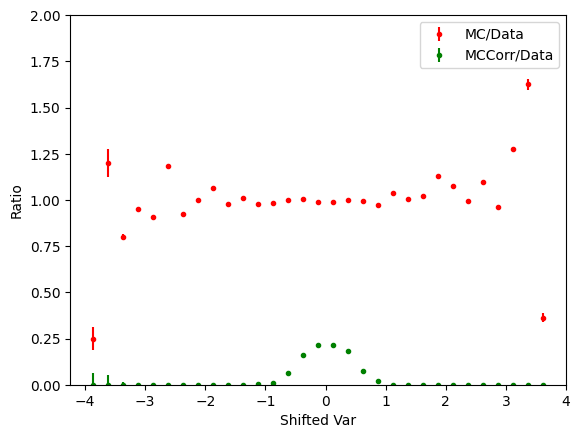

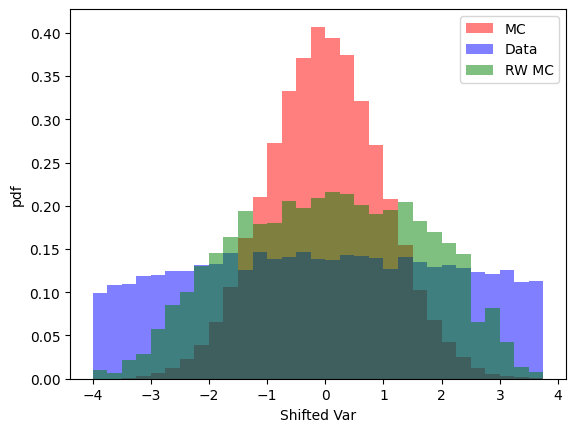

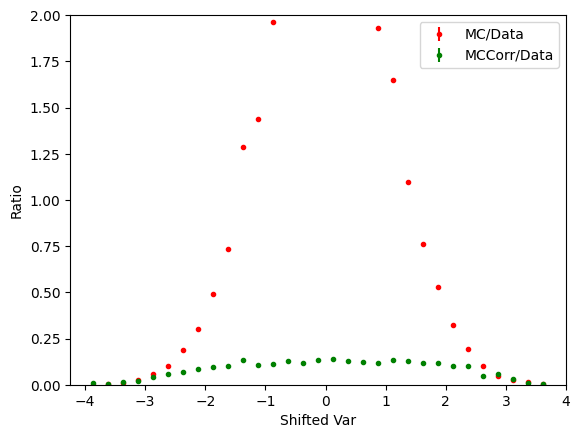

In [35]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])


/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 0.9828492069244384, p = 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.0886849117279054, p = 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 1.0106987273693084, p = 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.98it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 1.0860473012924194, p = 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: -0.12125006783287973, p = 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 1.073827097415924, p = 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: 1.0609100866317749, p = 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.10it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: 0.8812119174003601, p = 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.03it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.1038488221168519, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


Loss: 1.111138048171997, p = 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]


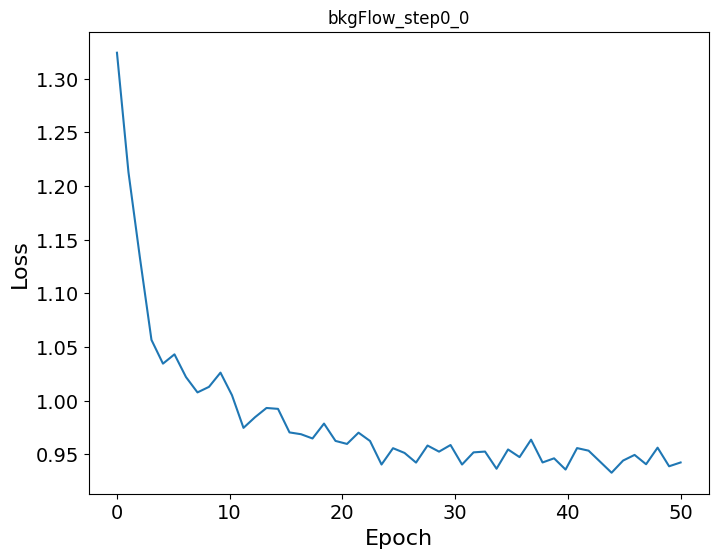

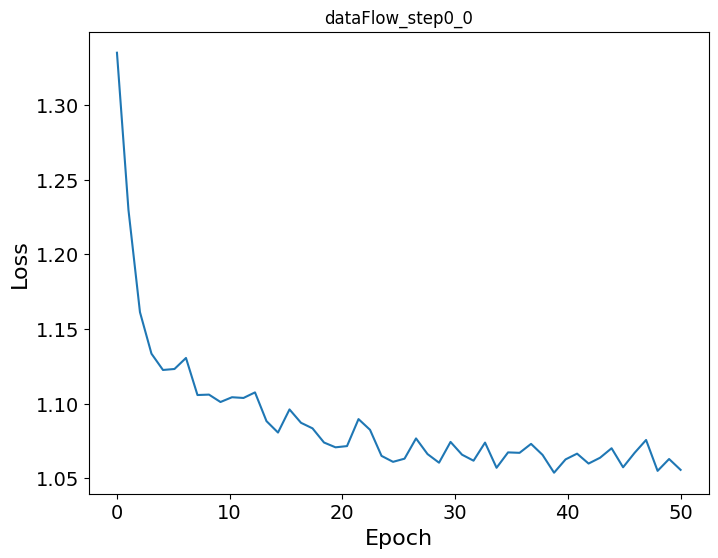

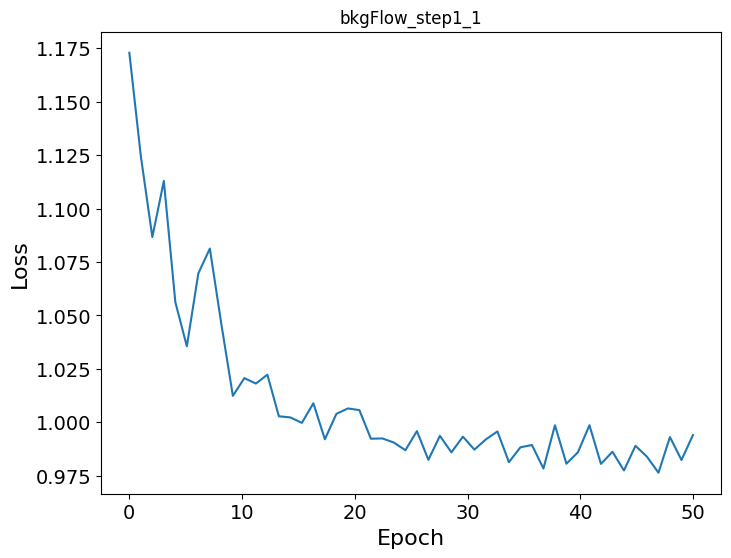

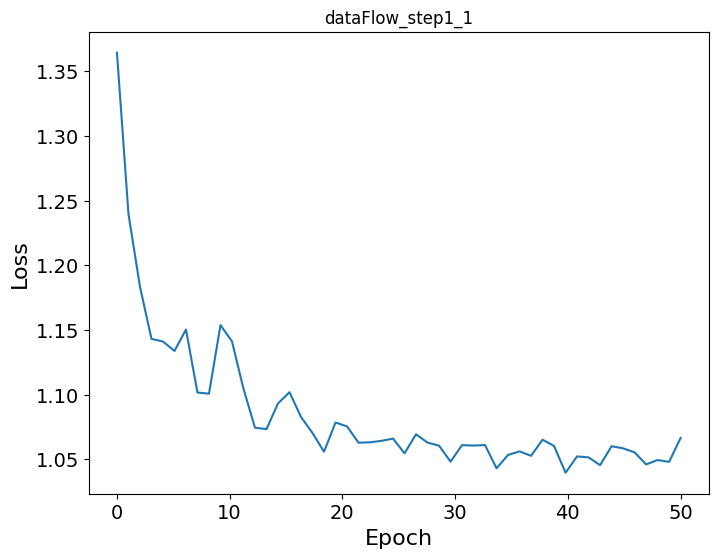

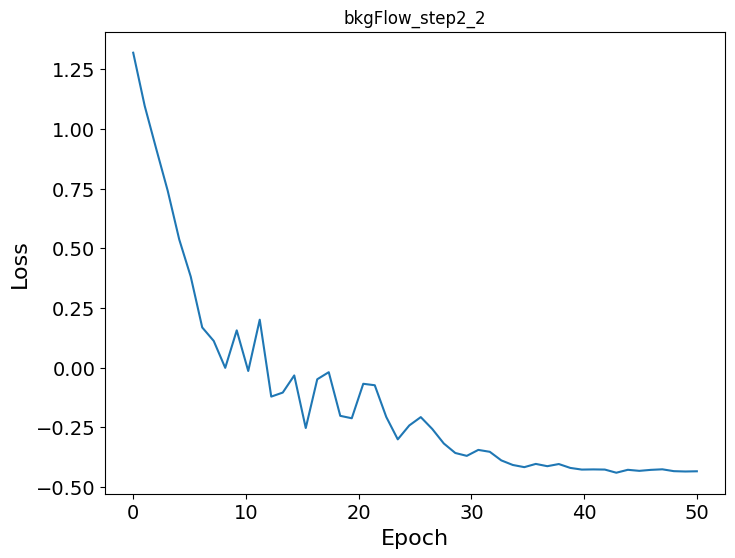

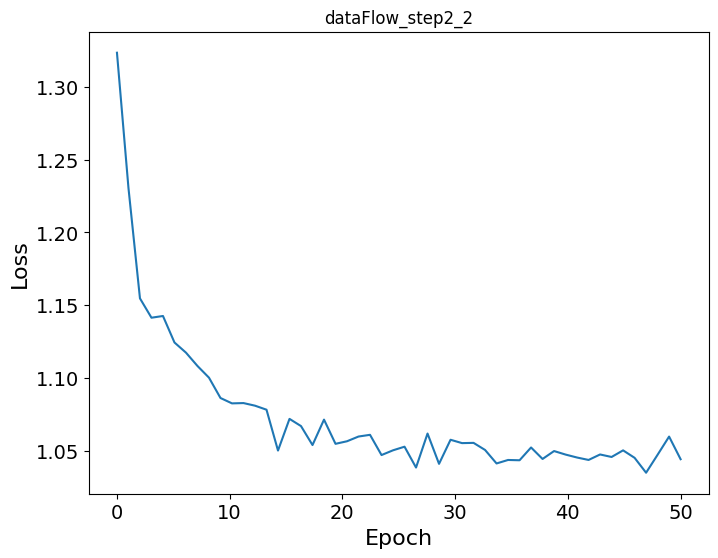

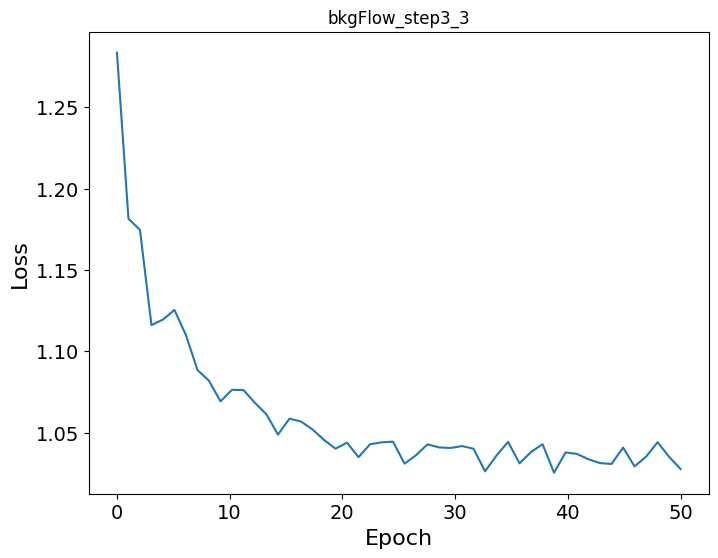

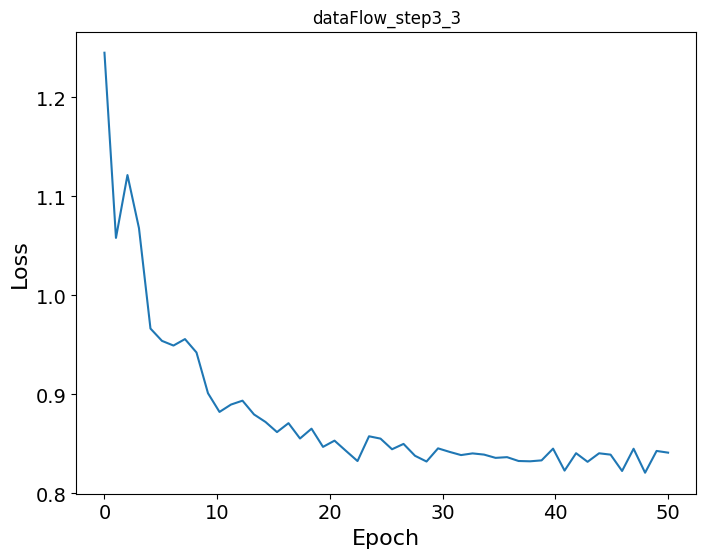

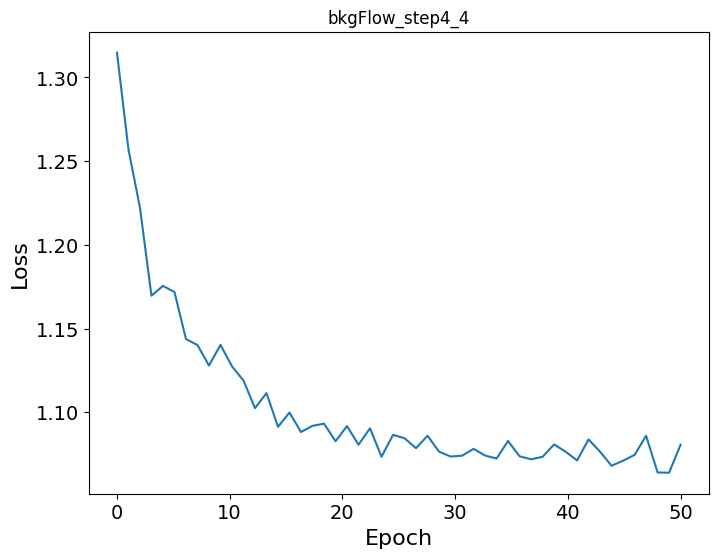

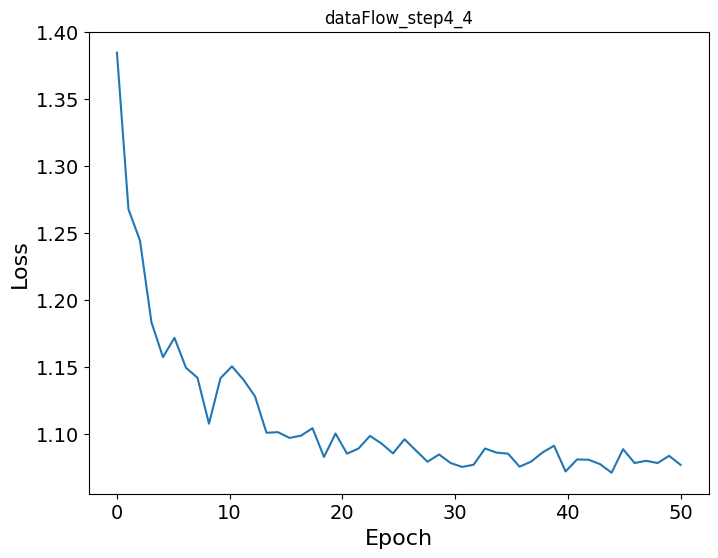

In [33]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)

  0%|                                                                                                                                                                       | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.06it/s]


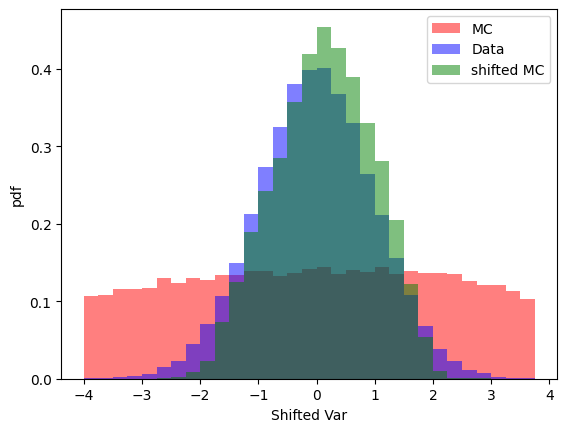

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


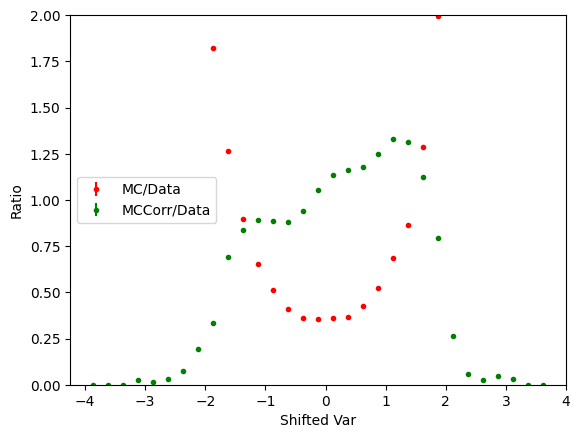

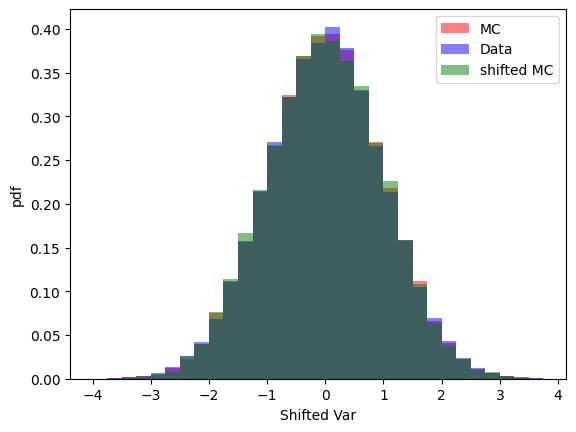

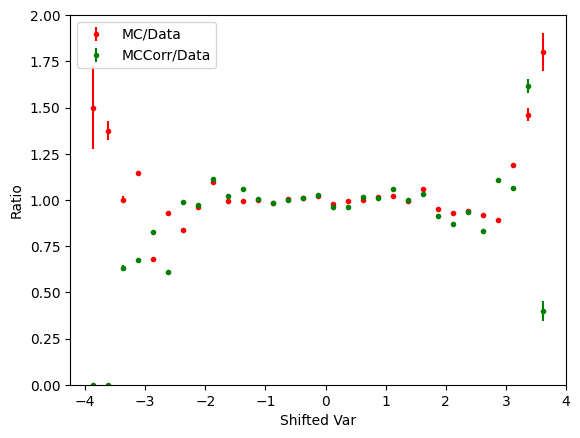

In [34]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])

## Variables that are additve

This is potentailly a case where reweight would work better, because it enforces kinematic conservation. The idea here is one of the variables, will be the exact sum of two variables in a similar way the jet mass is the sum of the 4-vectors. For this, we will shift two of teh variables by a small amount and then have the third variable be the sum ie 

$$
data_{1} = 1.05 mc_{1} \\
data_{2} = 1.15 mc_{2} \\
data_{3} = data_{1} + data_{2} \\
mc_{3} = mc_{1} + mc_{2} \\
v_{i} \in \mathcal{N}(0,1) \forall i \neq 3
$$

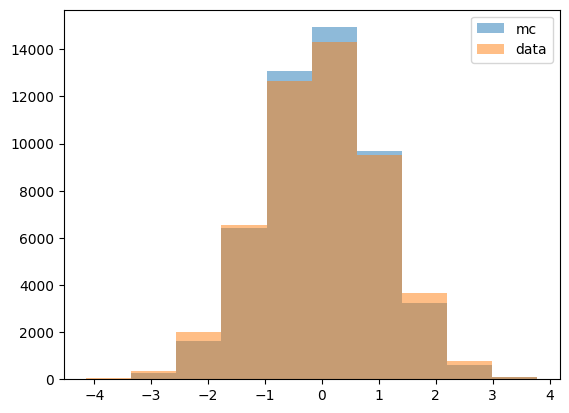

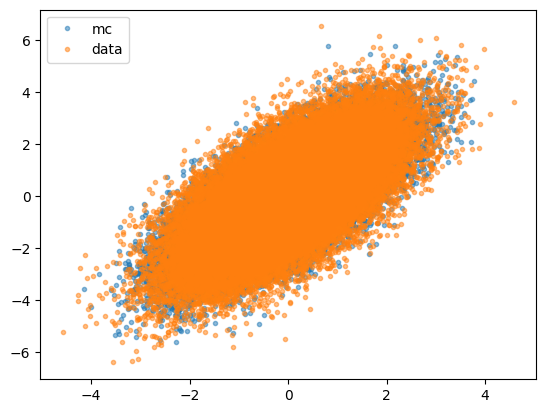

torch.Size([50000, 5])


In [72]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v2[:,1] *= 1.05
    v2[:,2] *= 1.15
    v1[:,3]  = v1[:,1] + v1[:,2]
    v2[:,3]  = v2[:,1] + v2[:,2]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,3],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,3],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Epoch: 0 LOSS train: 0.5910131931304932 
Epoch: 1 LOSS train: 0.7062644362449646 
Epoch: 2 LOSS train: 0.6920074224472046 
Epoch: 3 LOSS train: 0.7032754421234131 
Epoch: 4 LOSS train: 0.708842396736145 
Epoch: 5 LOSS train: 0.7101484537124634 
Epoch: 6 LOSS train: 0.7092032432556152 
Epoch: 7 LOSS train: 0.7075012922286987 
Epoch: 8 LOSS train: 0.7054386734962463 
Epoch: 9 LOSS train: 0.7035018801689148 
Epoch: 10 LOSS train: 0.6984601020812988 
Epoch: 11 LOSS train: 0.7078272104263306 
Epoch: 12 LOSS train: 0.7001267075538635 
Epoch: 13 LOSS train: 0.698413074016571 
Epoch: 14 LOSS train: 0.6975647211074829 
Epoch: 15 LOSS train: 0.6969460248947144 
Epoch: 16 LOSS train: 0.6964377760887146 
Epoch: 17 LOSS train: 0.6960384249687195 
Epoch: 18 LOSS train: 0.6957759857177734 
Epoch: 19 LOSS train: 0.6955334544181824 
Epoch: 20 LOSS train: 0.695296049118042 
Epoch: 21 LOSS train: 0.695156991481781 
Epoch: 22 LOSS train: 0.694953441619873 
Epoch: 23 LOSS train: 0.6948582530021667 
Epoch: 

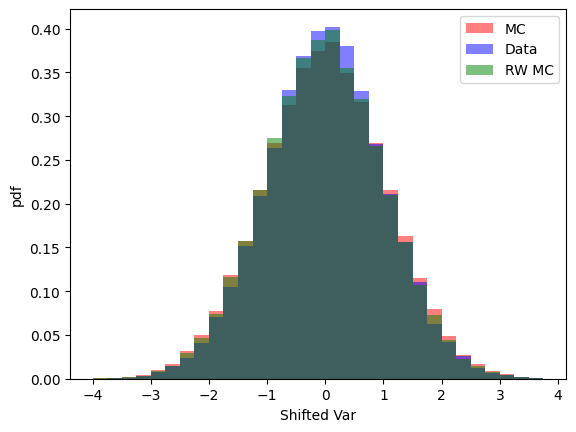

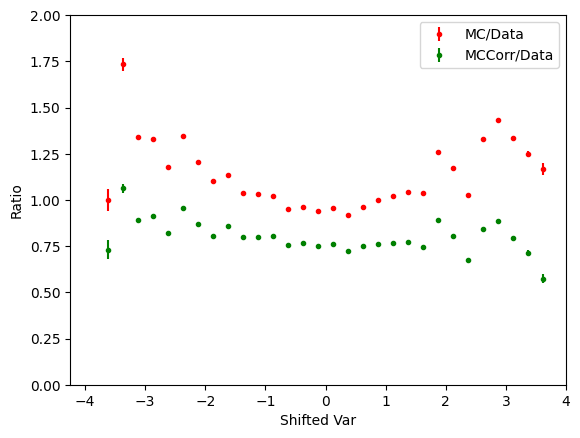

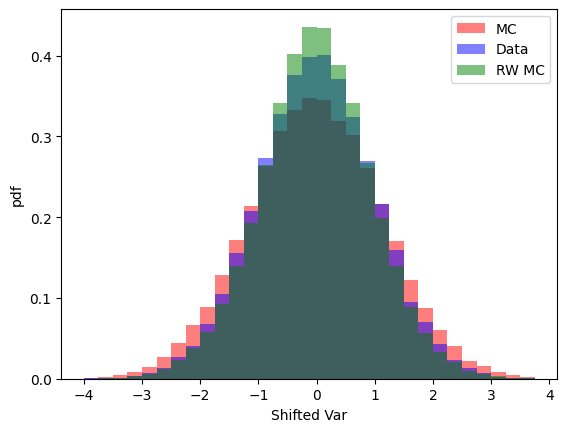

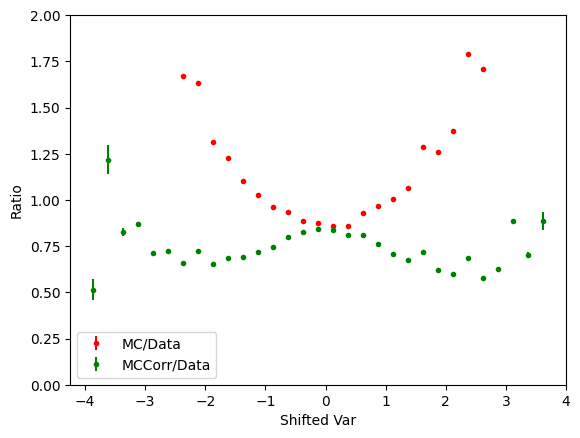

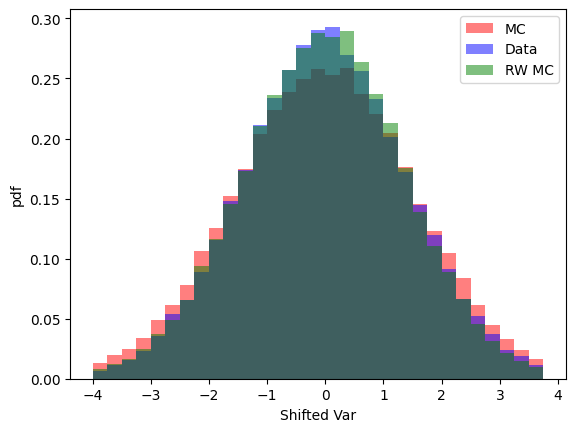

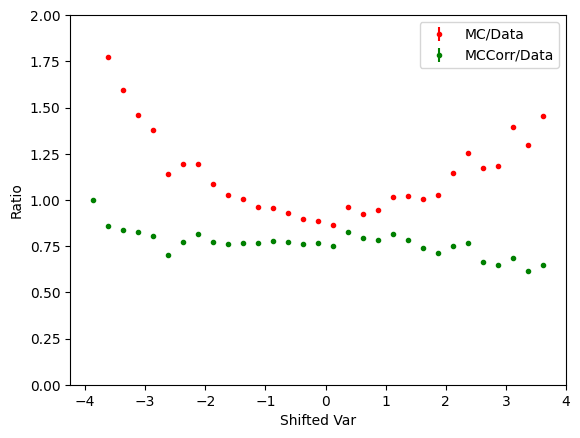

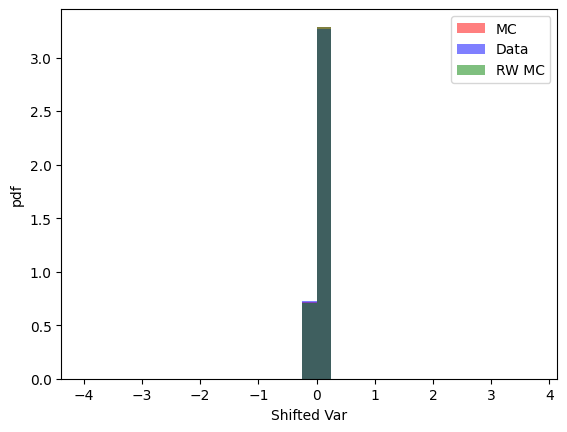

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


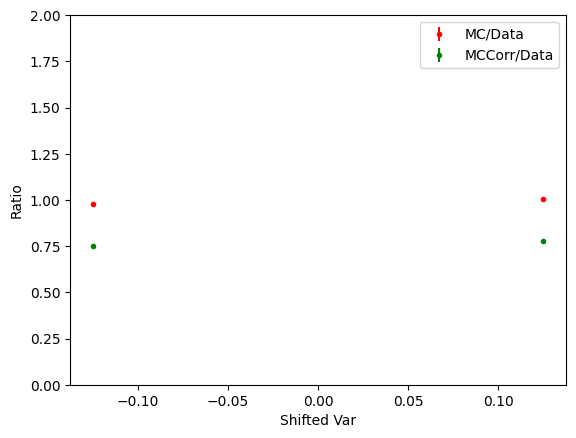

In [50]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
weightedComp(test_in[:,3][label_in==1],test_in[:,3][label_in==0],weight[label_in==0])

data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
weightedComp(data_conserved,mc_conserved,weight[label_in==0])



/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.07212060213089, p = 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.21it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.096247959136963, p = 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 1.0471382546424866, p = 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 1.1100321125984192, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: 1.1620674896240235, p = 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 1.0542476272583008, p = 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: -0.502765902876854, p = 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.52it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: -0.5452796564903111, p = 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.1034806180000305, p = 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


Loss: 1.1577088618278504, p = 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


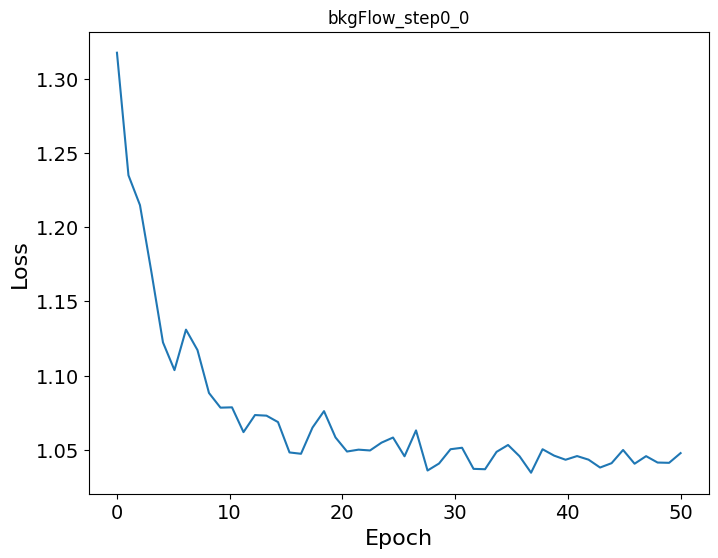

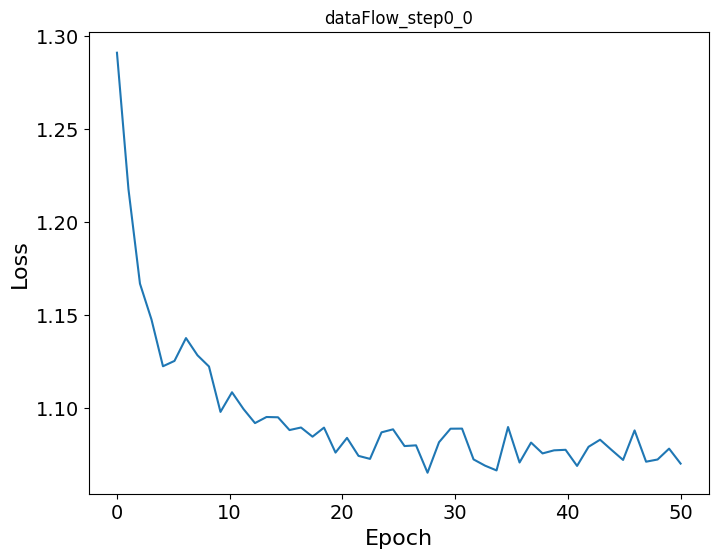

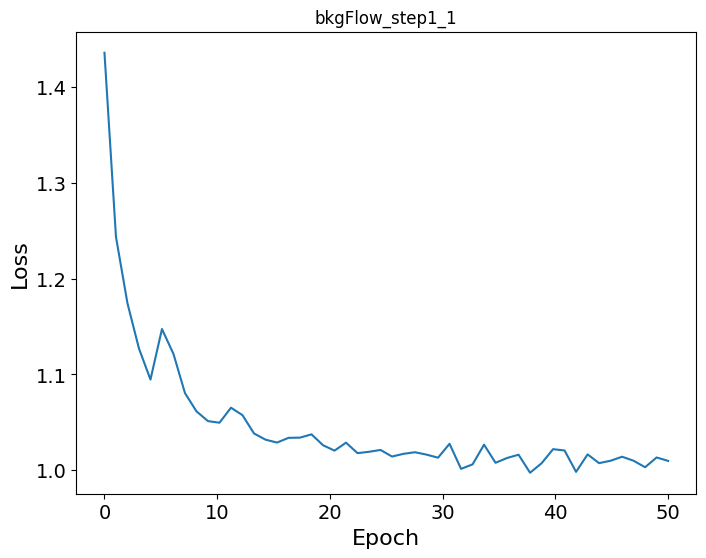

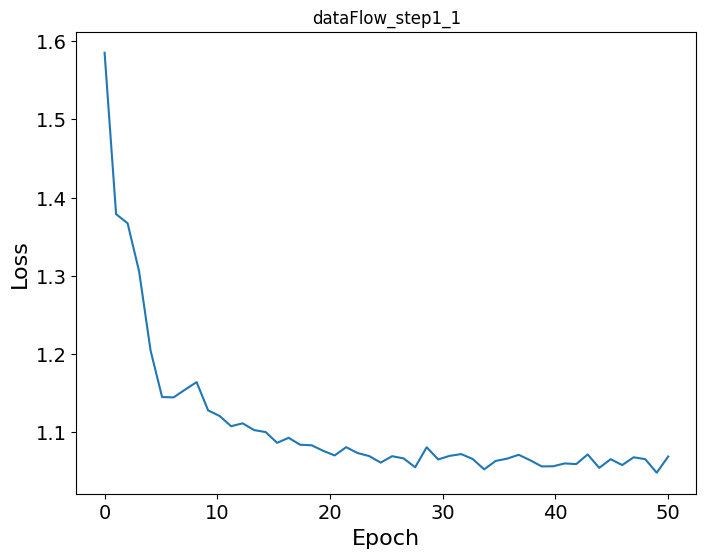

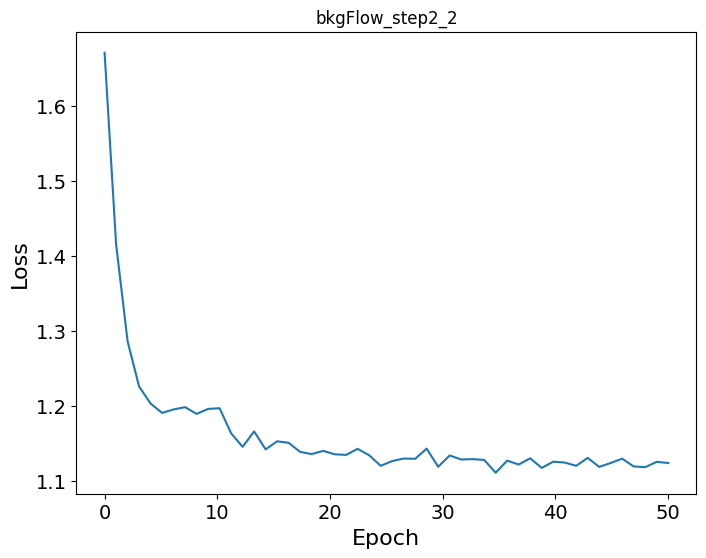

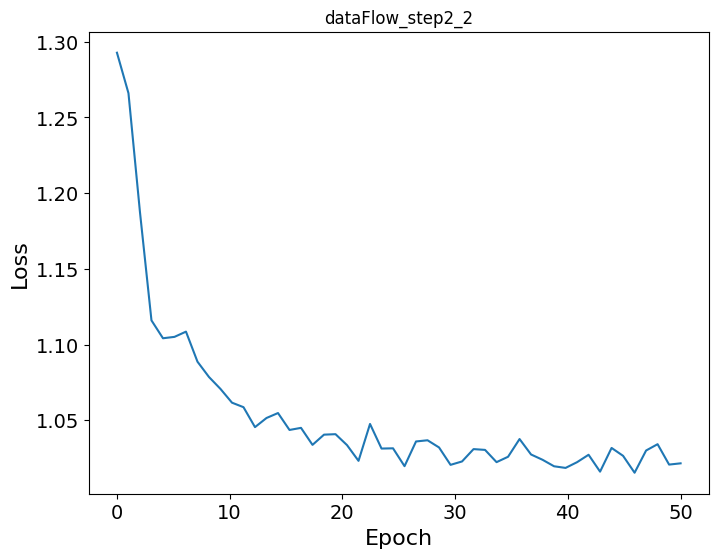

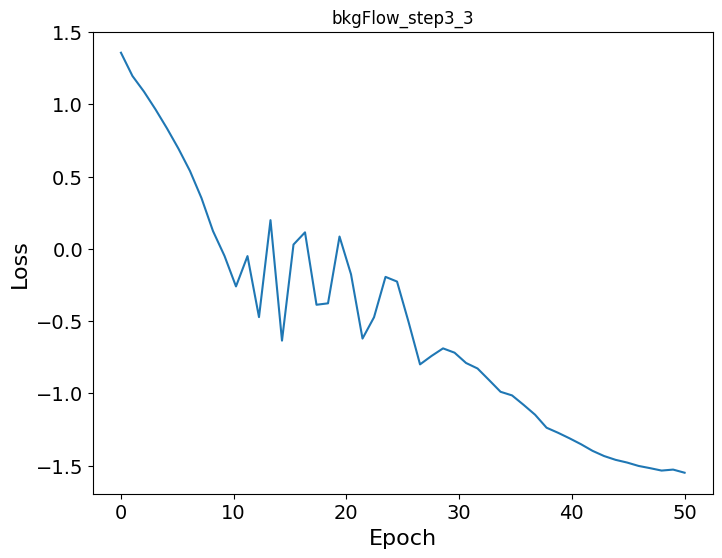

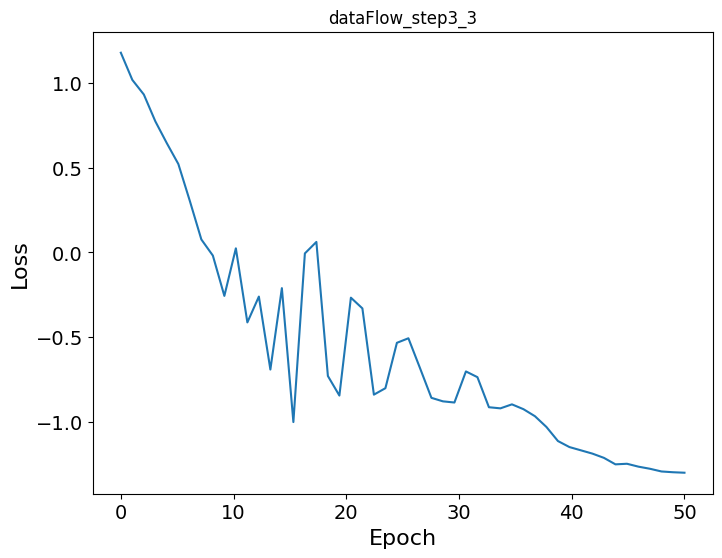

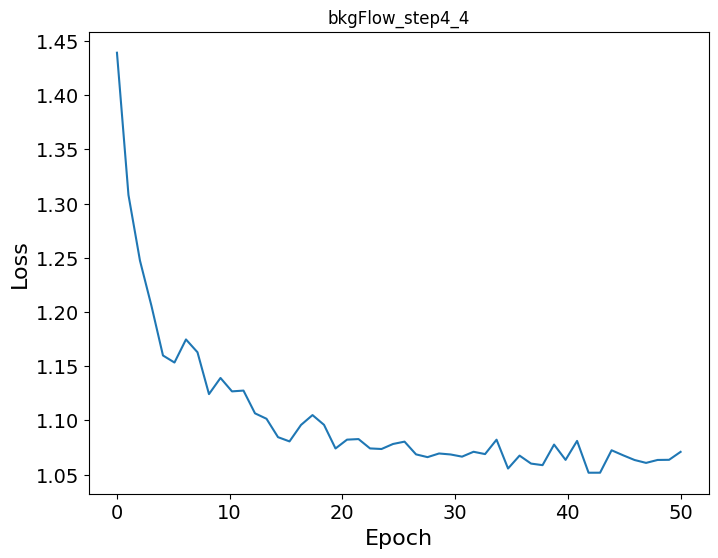

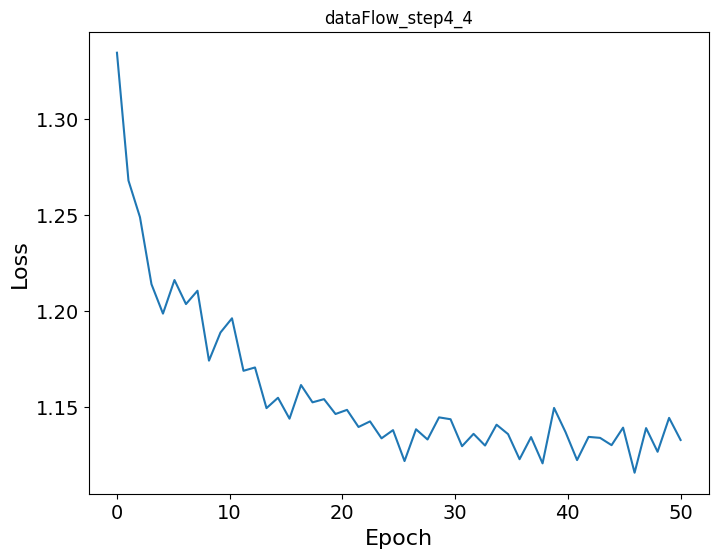

In [39]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.11it/s]


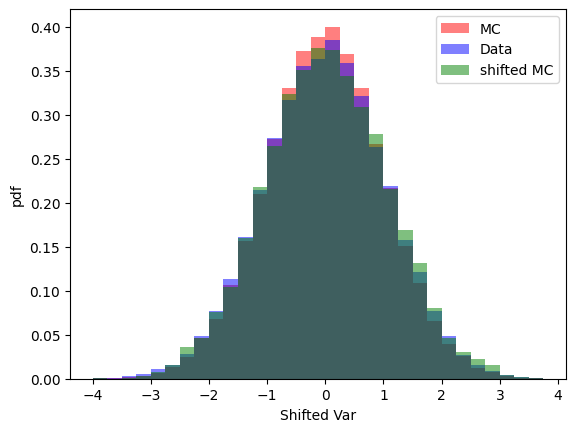

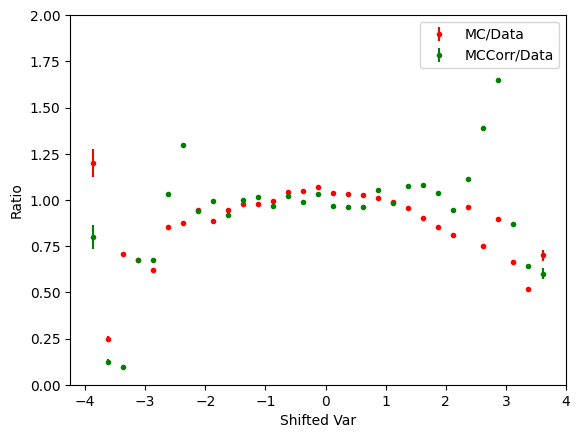

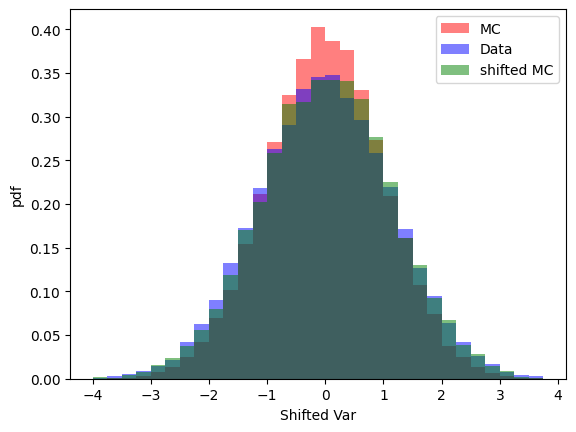

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)


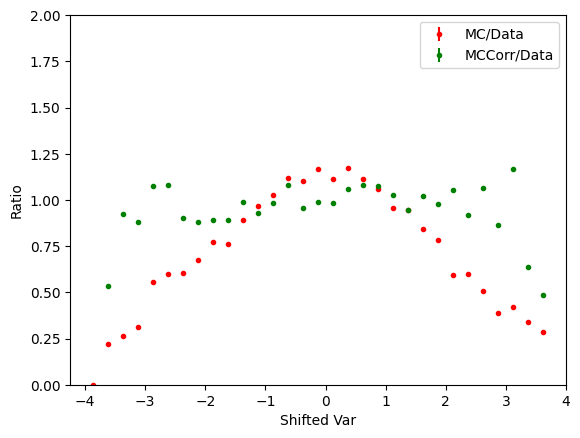

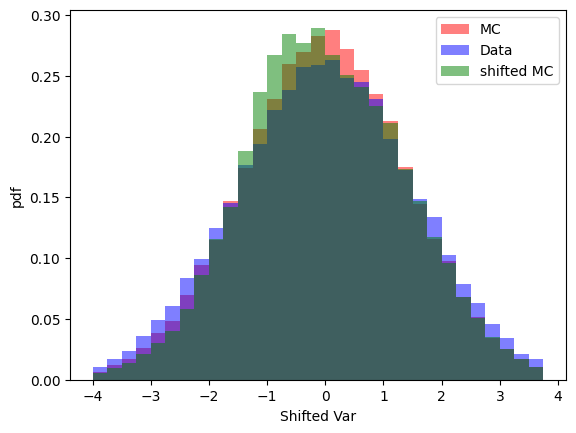

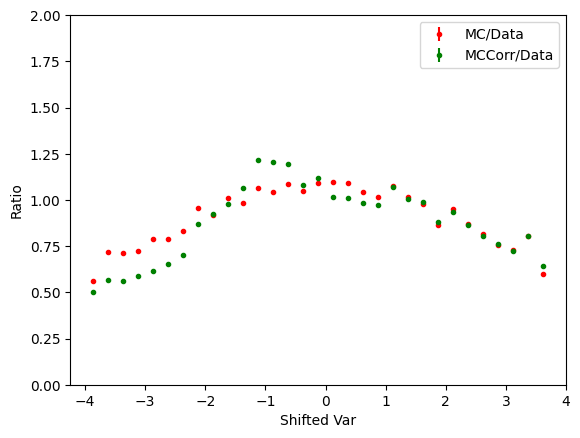

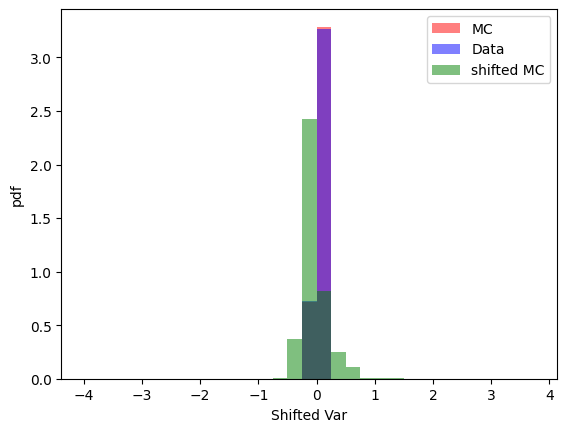

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


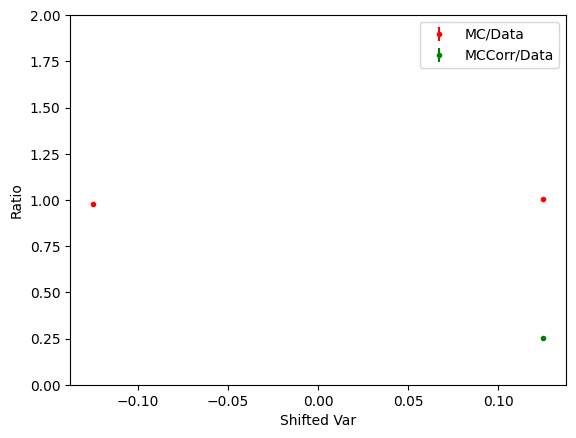

In [49]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
mccorr_conserved=mccorr_train['3']-mccorr_train['2']-mccorr_train['1']
quantileComp(data_conserved,mc_conserved,mccorr_conserved)



In [90]:
##swapping order just ot test
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v2[:,2] *= 1.05
    v2[:,3] *= 1.15
    v1[:,1]  = v1[:,2] + v1[:,3]
    v2[:,1]  = v2[:,2] + v2[:,3]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,3],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,3],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
#outdata,_,_=makeDataSet()
#print(outdata[0])

/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.1277515506744384, p = 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.04it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.0699508333206176, p = 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.21it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 1.0674404716491699, p = 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 1.0492850017547608, p = 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: 0.8135939157009124, p = 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.94it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 0.8278409504890442, p = 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.18it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: -0.3609011613950133, p = 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: -0.4363415676355362, p = 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.075280919075012, p = 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.21it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                       | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.44it/s]


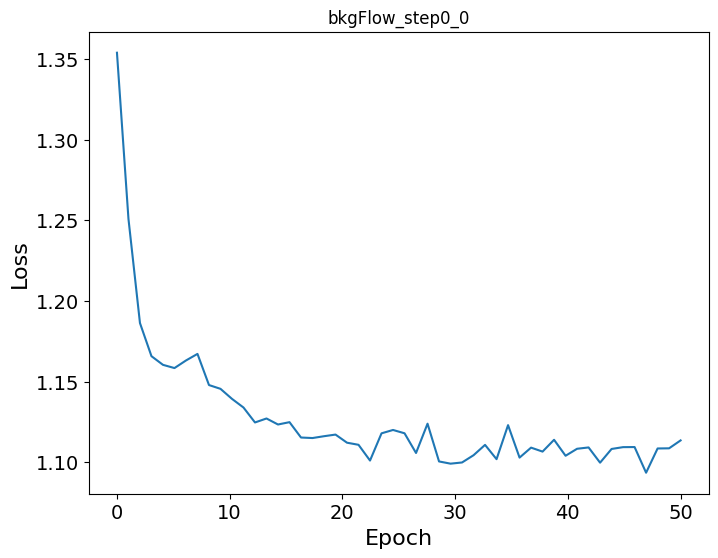

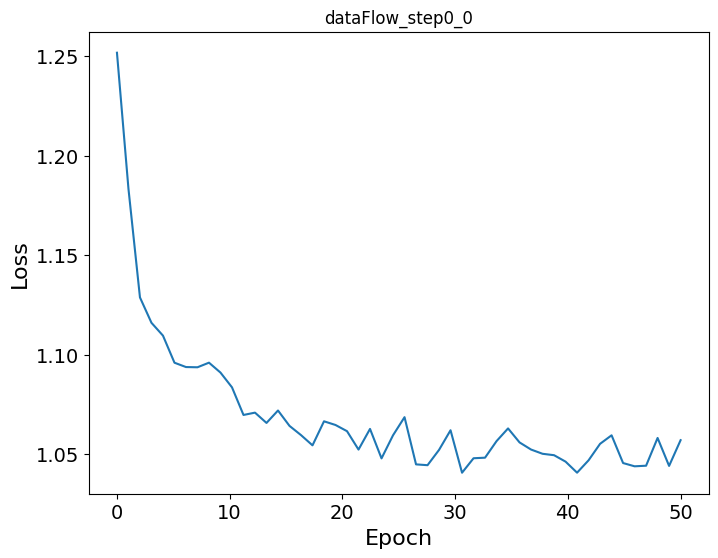

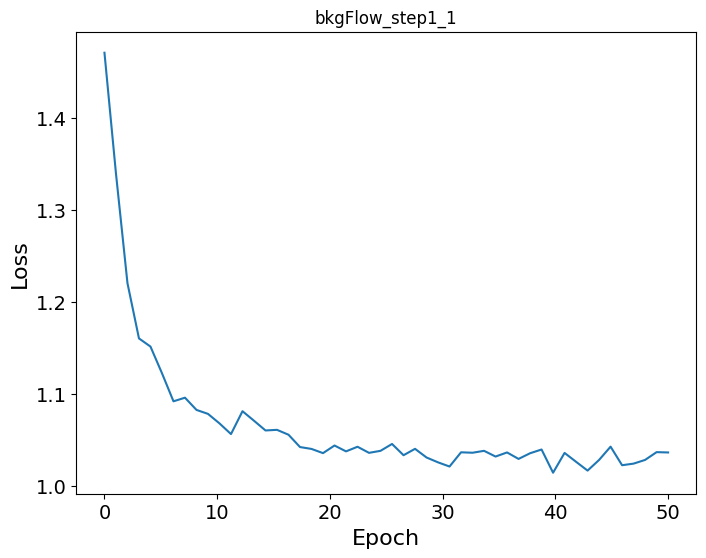

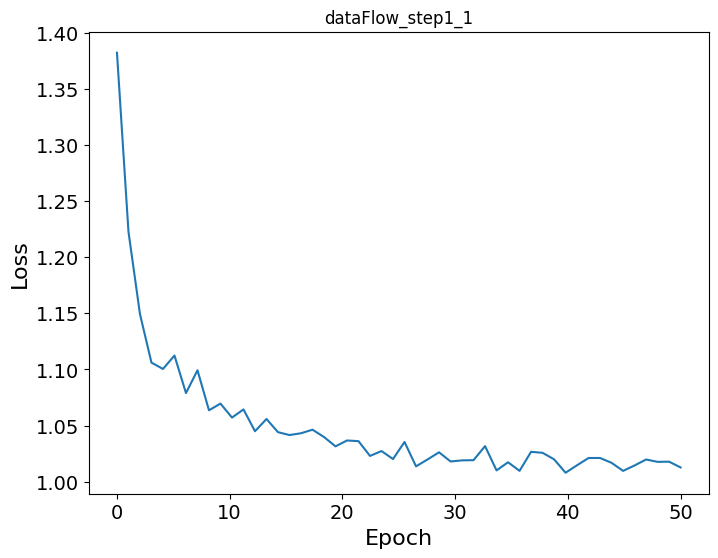

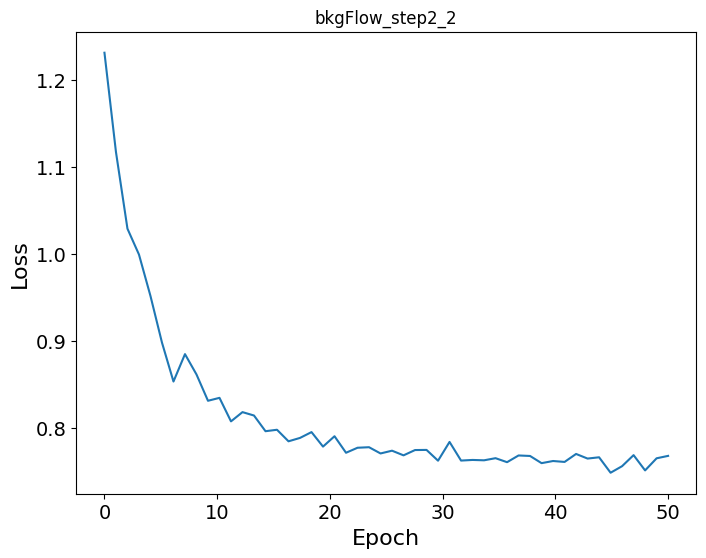

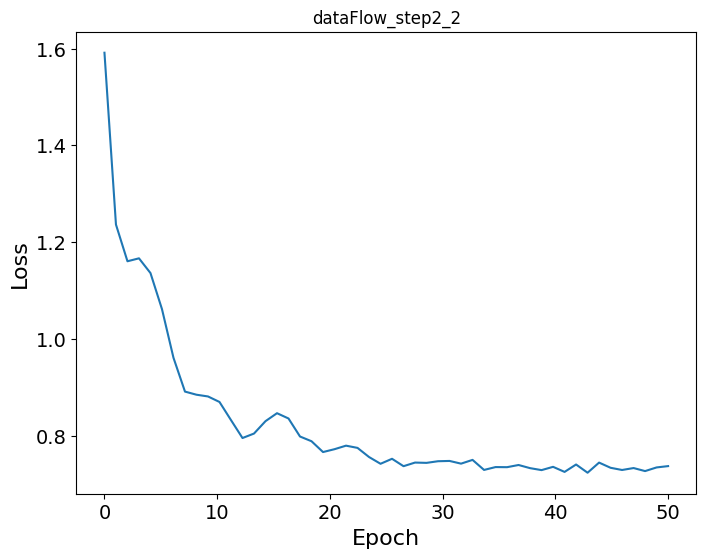

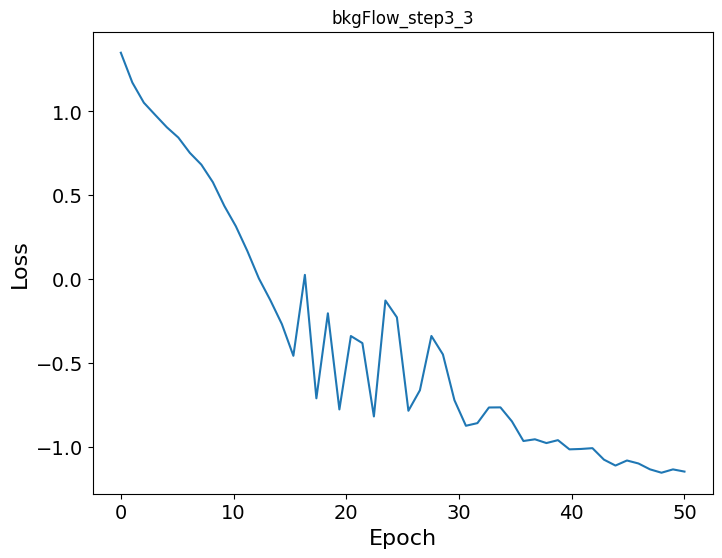

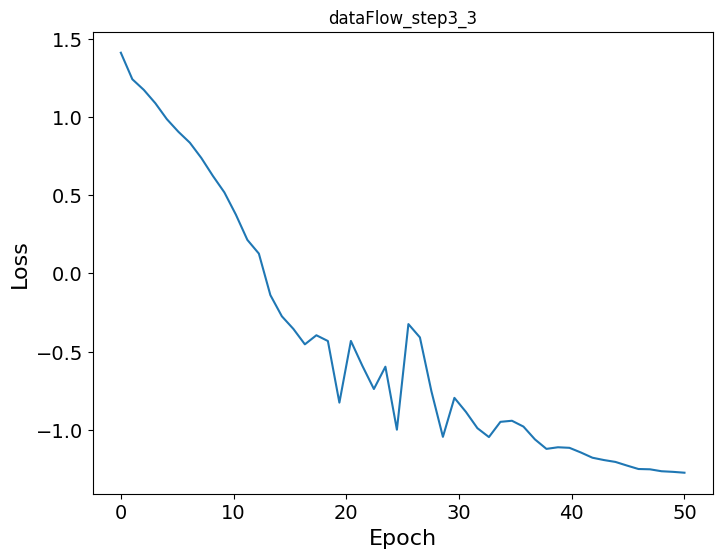

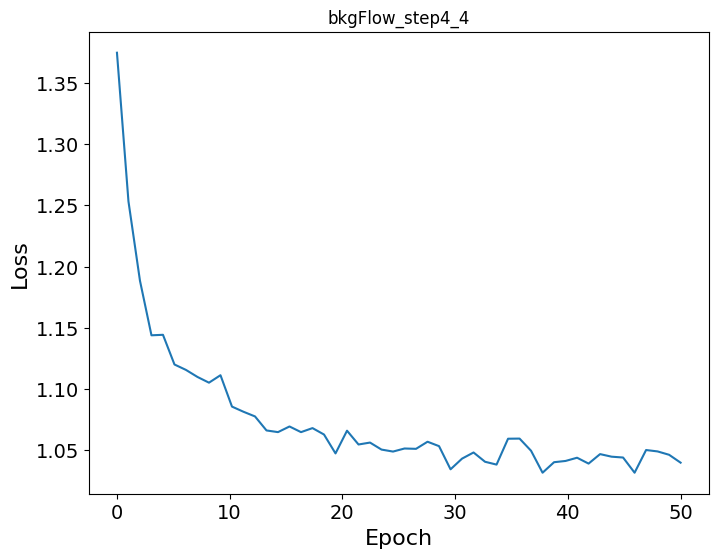

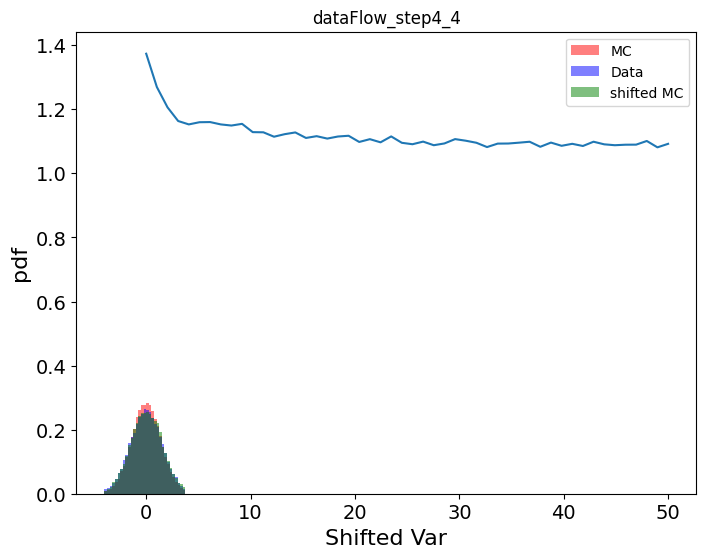

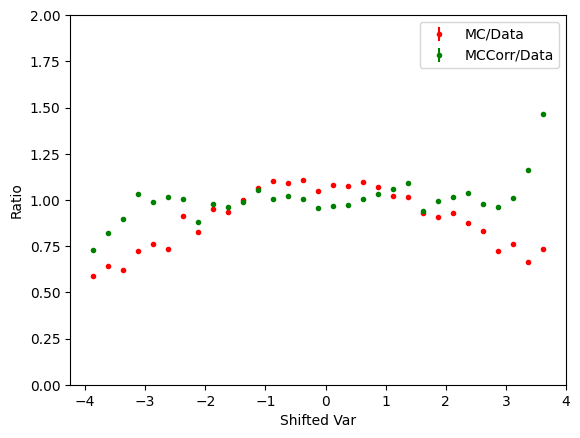

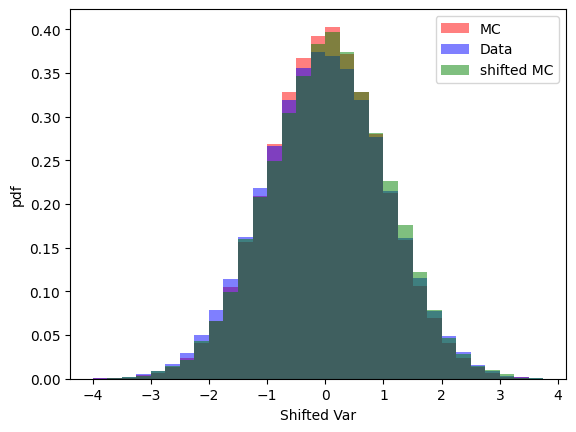

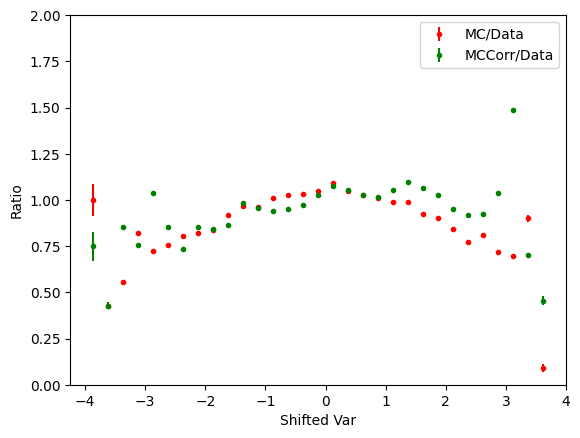

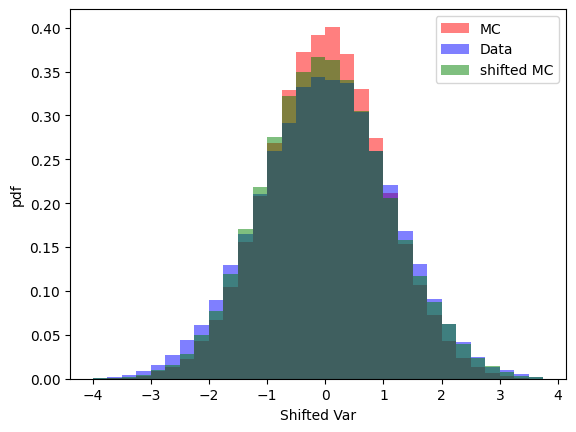

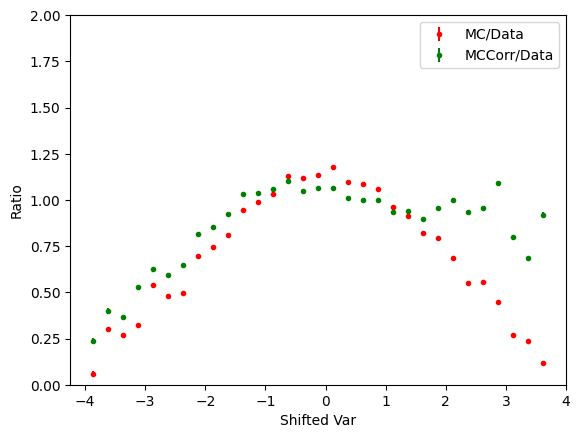

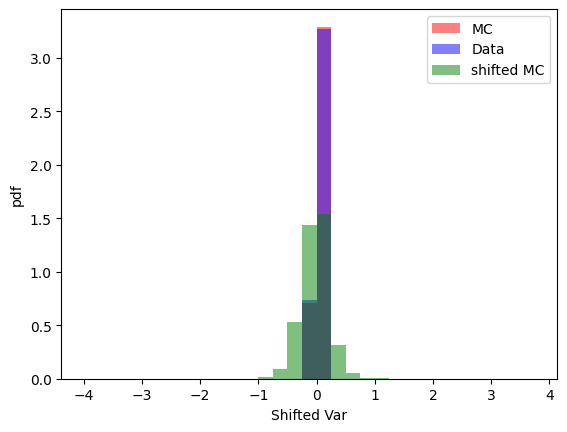

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


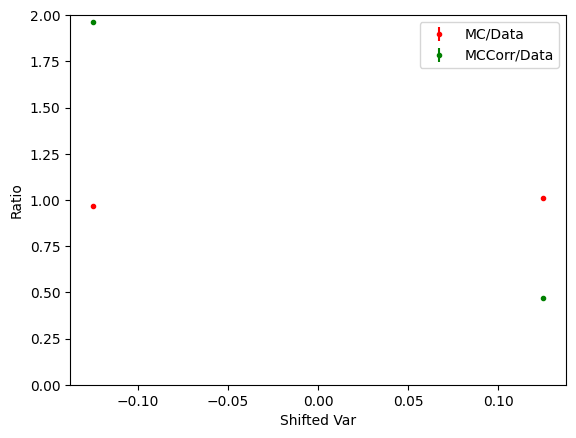

In [52]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,1]-data_train[:,3]-data_train[:,2]
mc_conserved=mc_train[:,1]-mc_train[:,3]-mc_train[:,2]
mccorr_conserved=mccorr_train['1']-mccorr_train['3']-mccorr_train['2']
quantileComp(data_conserved,mc_conserved,mccorr_conserved)



I think from all of this, we conclude that invariant quantities need to be reconstructed in some appropriately systematic way, whether you shift the combined quantity vs the individual, conservation laws are always broken unless enforced, this is what reweight gives you. 

## Now finally a realistic example

We will sammple an expoentially falling distribution that is a proxy for jet pT, which changes as a function of eta. We will then sample eta, then an adjust jet mass correlated with jet pT, and a jet substructure variable that is less correlated. 

$$
v_{0} = \mathcal{U}(0,3)\\
v_{1} = e^{-1000v_{1}x} \\
data_{1} = mc_{1}\times1.02\\
v_{2} = \mathcal{N}(0,10)+v_{1}/500 \\
v_{3} = \mathcal{N}(0,1) +v_{1}/5000 \\
v_{i} \in \mathcal{N}(0,1) \forall i \geq 4
$$

In [114]:
def makeDataSet(iN=50000,iDim=5,iControl=False,iPlot=False):
    e1=torch.rand(iN)
    e2=torch.rand(iN)
    if iControl:
        e1+=2
        e2+=2
    p1=np.random.exponential(1000*e1,size=(iN))
    p2=np.random.exponential(1000*e2,size=(iN))*1.02
    v1=torch.randn(iN,iDim-2)
    v2=torch.randn(iN,iDim-2)
    #v1[:,0]*=10
    #v2[:,0]*=10
    v1[:,0]+=p1/500.
    v2[:,0]+=p2/500.
    v1[:,1]+=p1/5000.
    v2[:,1]+=p1/5000.
    p1*=0.001
    p2*=0.001
    if iPlot:
        _,bins,_=plt.hist(p1,alpha=0.5,label='mc')
        plt.hist(p2,bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,0],v1[:,1],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,0],v2[:,1],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    p1=torch.tensor(p1,dtype=None)
    p2=torch.tensor(p2,dtype=None)
    v1=torch.vstack((e1,p1.float(),v1.T))
    v2=torch.vstack((e2,p1.float(),v2.T))
    v1=v1.T
    v2=v2.T
    tot=torch.cat([v1,v2])
    #print(tot)
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=False)
datacontrol,_,_=makeDataSet(iControl=False)
#outdata,_,_=makeDataSet()
#print(outdata[0])

Epoch: 0 LOSS train: 0.6003957390785217 
Epoch: 1 LOSS train: 0.7077146172523499 
Epoch: 2 LOSS train: 0.6814597249031067 
Epoch: 3 LOSS train: 0.6810171604156494 
Epoch: 4 LOSS train: 0.6786536574363708 
Epoch: 5 LOSS train: 0.6743709444999695 
Epoch: 6 LOSS train: 0.6693100929260254 
Epoch: 7 LOSS train: 0.6633753776550293 
Epoch: 8 LOSS train: 0.6568489670753479 
Epoch: 9 LOSS train: 0.6498687863349915 
Epoch: 10 LOSS train: 0.6428366303443909 
Epoch: 11 LOSS train: 0.6356934309005737 
Epoch: 12 LOSS train: 0.628722071647644 
Epoch: 13 LOSS train: 0.6223368048667908 
Epoch: 14 LOSS train: 0.6165829300880432 
Epoch: 15 LOSS train: 0.6116598844528198 
Epoch: 16 LOSS train: 0.607627809047699 
Epoch: 17 LOSS train: 0.6041805148124695 
Epoch: 18 LOSS train: 0.6014630198478699 
Epoch: 19 LOSS train: 0.5992843508720398 
Epoch: 20 LOSS train: 0.5974928736686707 
Epoch: 21 LOSS train: 0.5960556268692017 
Epoch: 22 LOSS train: 0.5947757959365845 
Epoch: 23 LOSS train: 0.5937868356704712 
Epoc

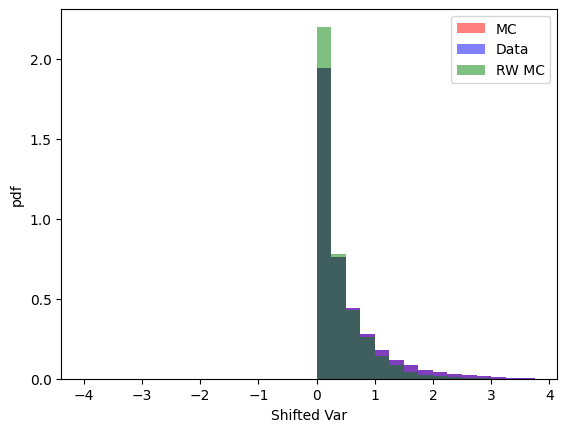

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


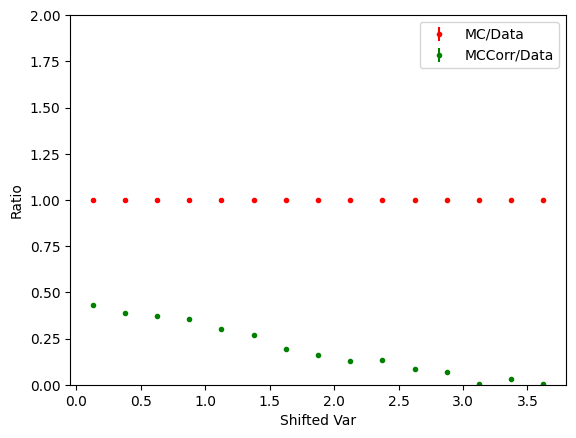

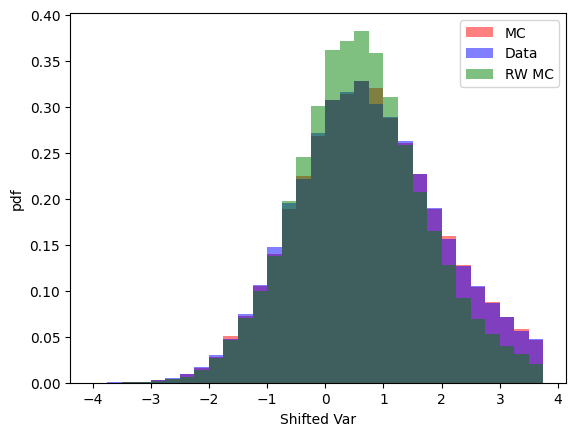

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)


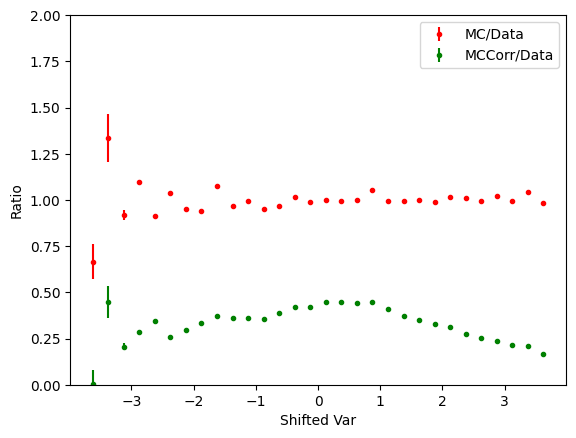

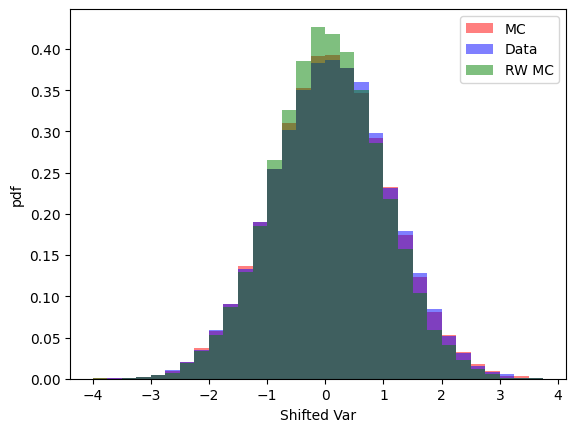

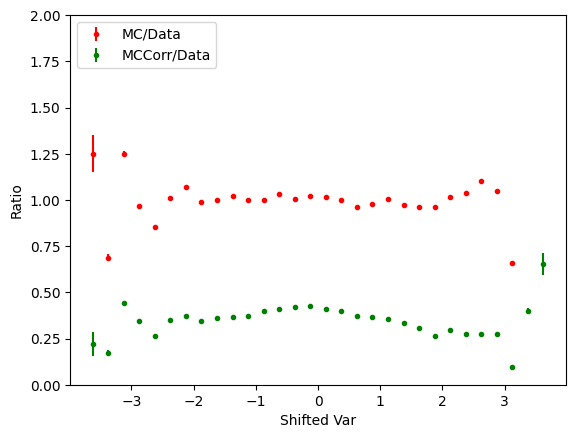

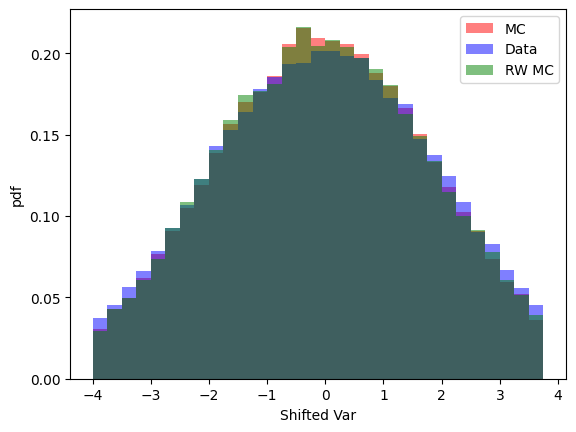

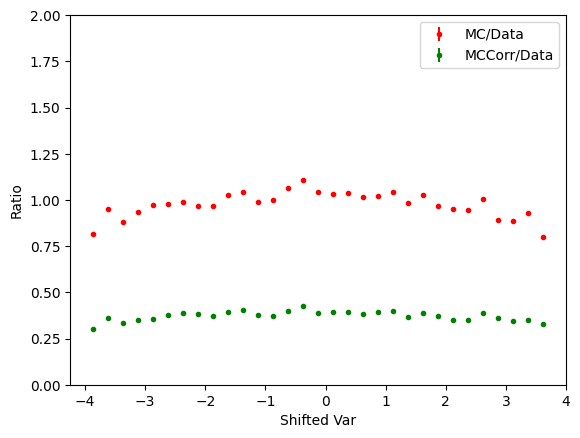

In [115]:
rw_model = simple_MLP_onelayer(datacontrol,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet(iControl=False)
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
weightedComp(test_in[:,3][label_in==1],test_in[:,3][label_in==0],weight[label_in==0])

data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
weightedComp(data_conserved,mc_conserved,weight[label_in==0])


/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.8608733415603638, p = 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.01it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


Loss: 1.8645911049842834, p = 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step1_1


Loss: 0.3086306278267875, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.02it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


Loss: 0.37401163108181207, p = 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  5.00it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step2_2


Loss: 0.34642049223184584, p = 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.94it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


Loss: 0.5683687055110931, p = 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step3_3


Loss: 1.0914452052116395, p = 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


Loss: 1.0698087048530578, p = 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.02it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step4_4


Loss: 1.0843091201782227, p = 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.19it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                       | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.75it/s]


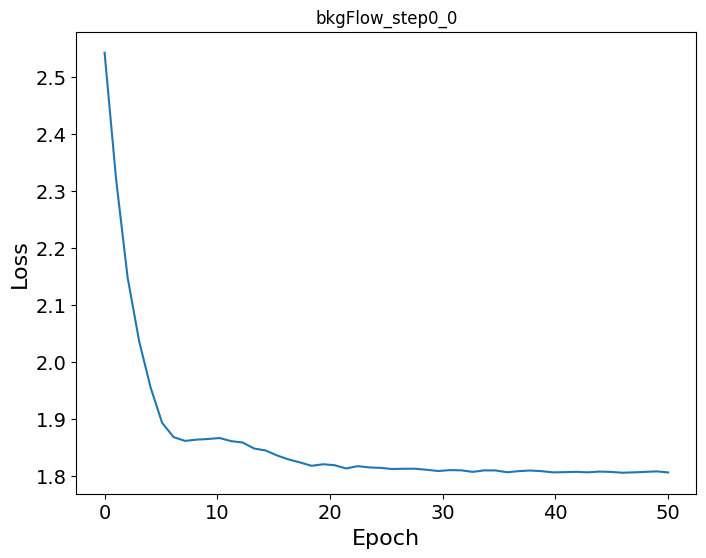

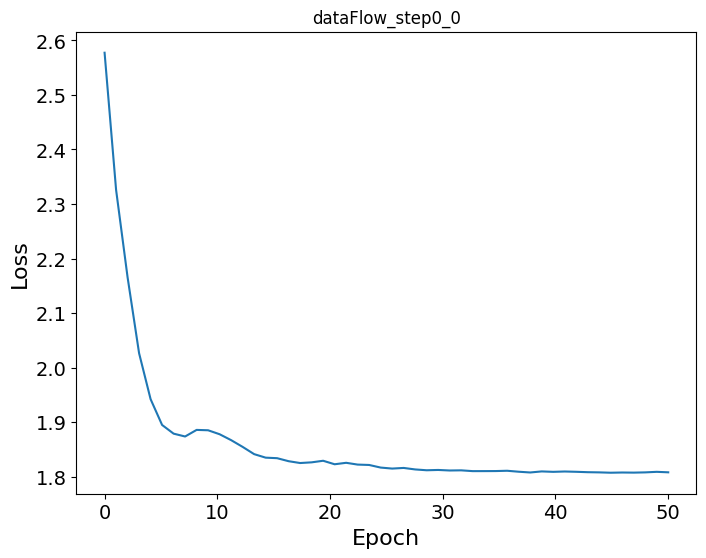

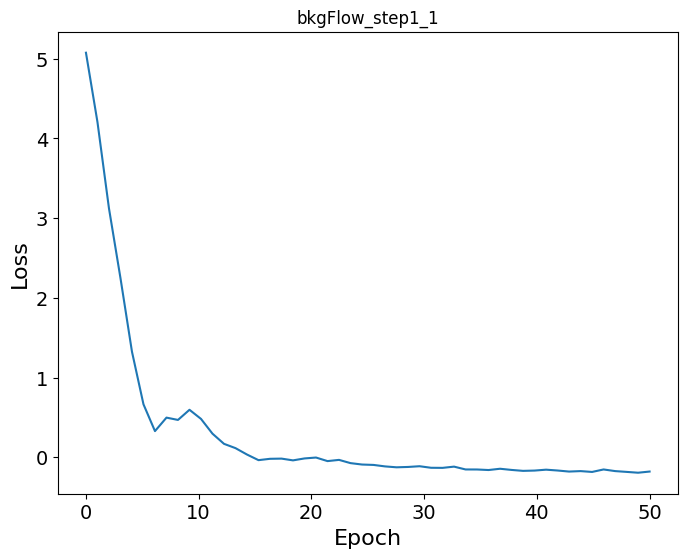

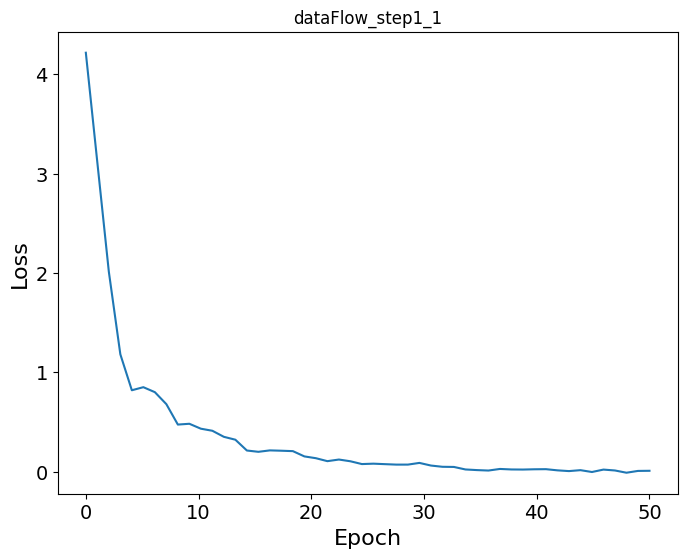

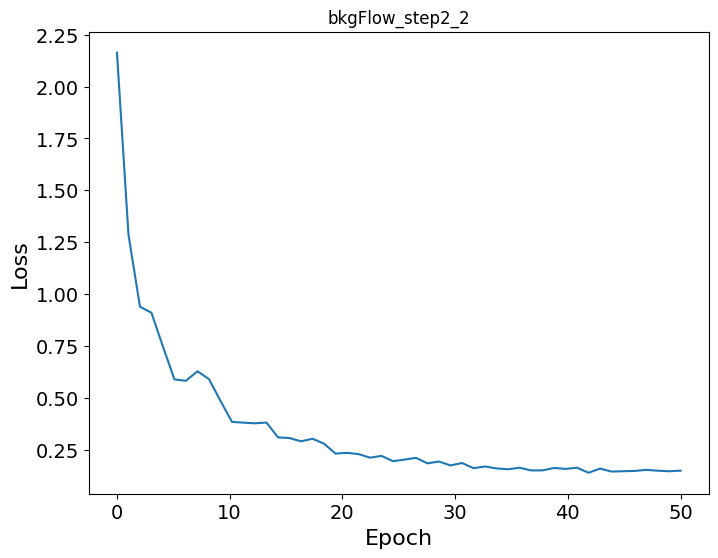

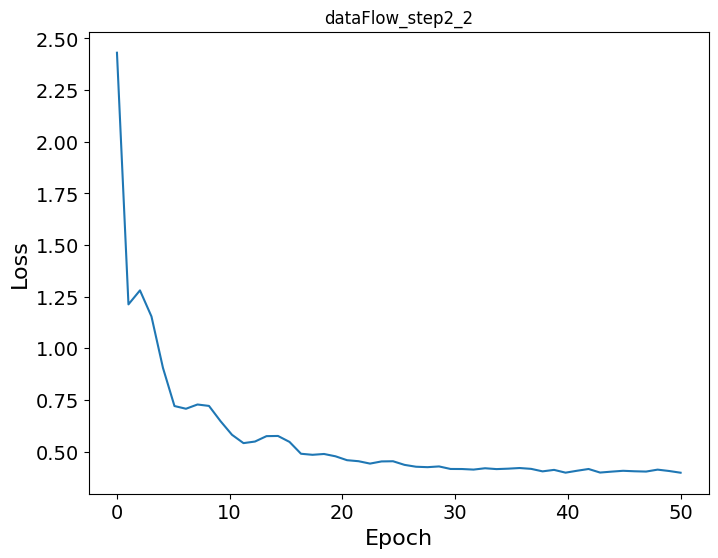

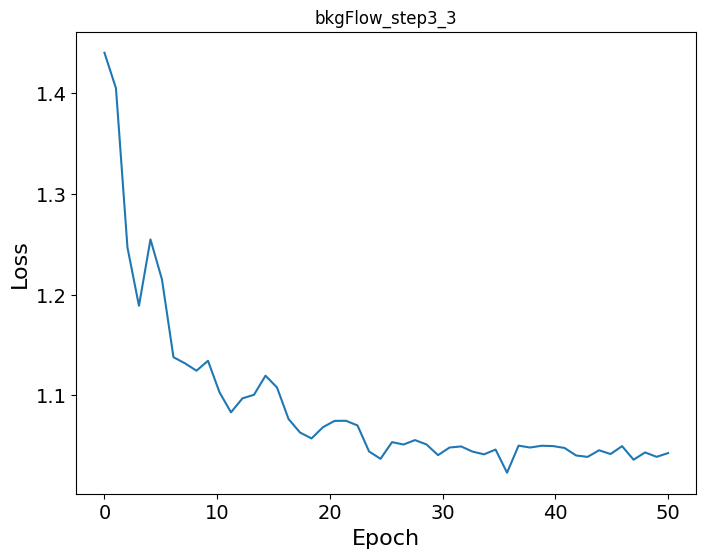

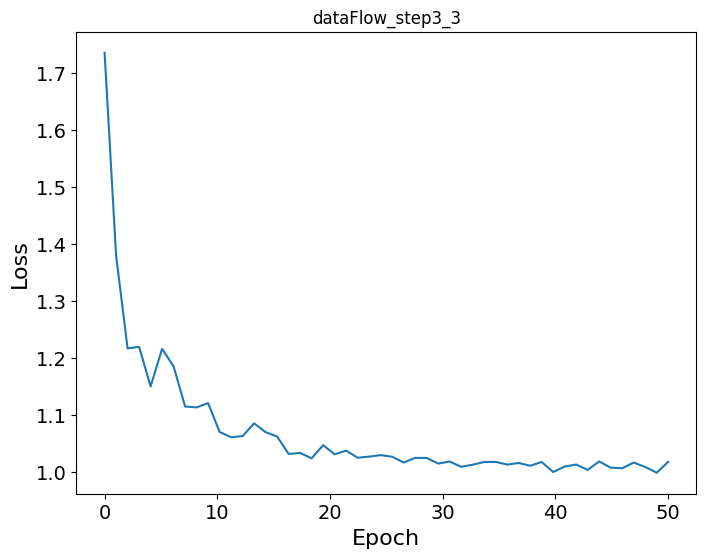

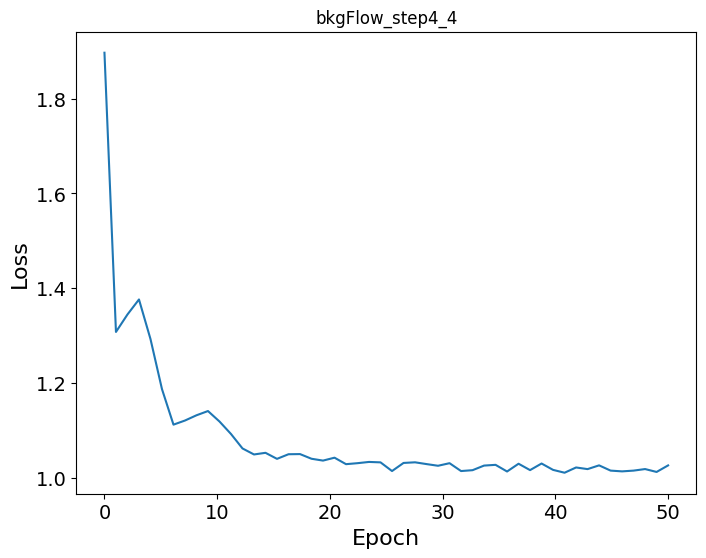

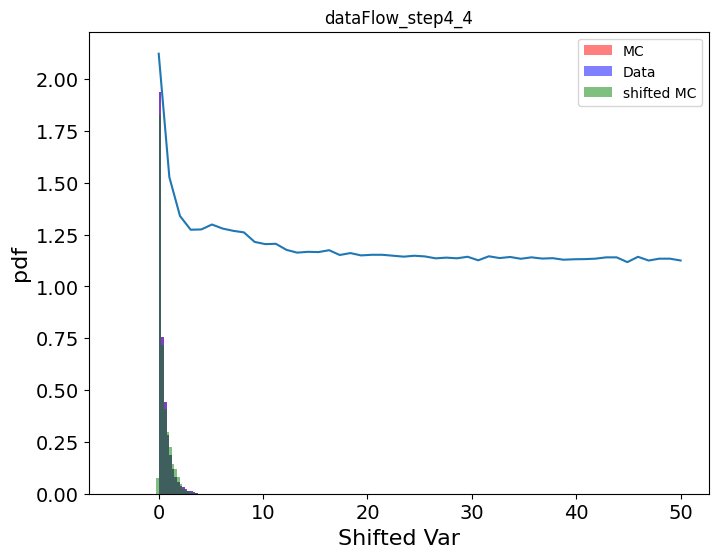

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1/iMC)**2+(ratio1/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_15902/3844691258.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2/iMCCorr)**2+(ratio2/iData)**2)
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


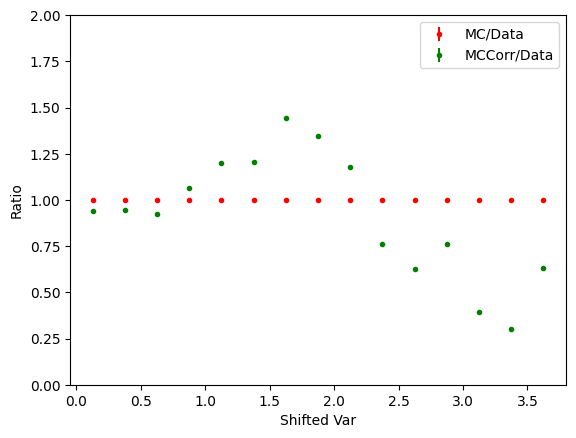

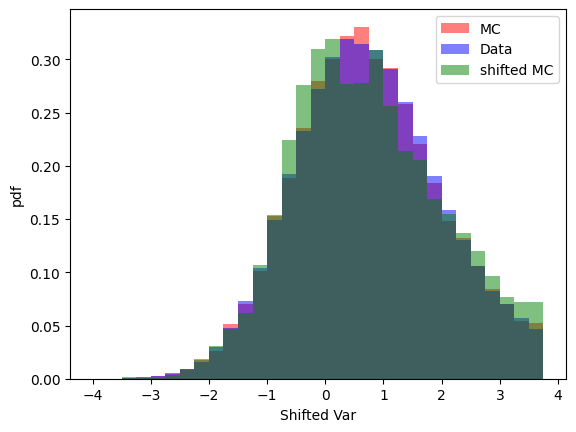

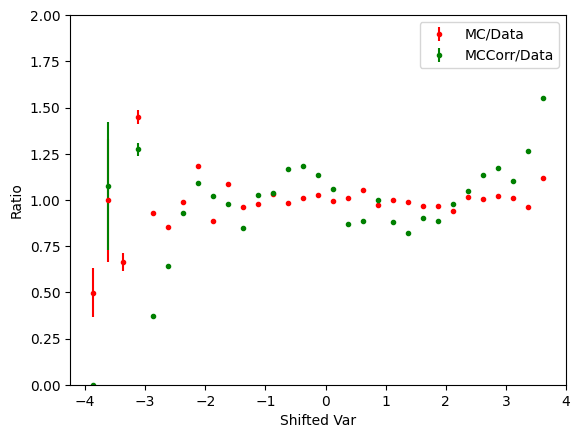

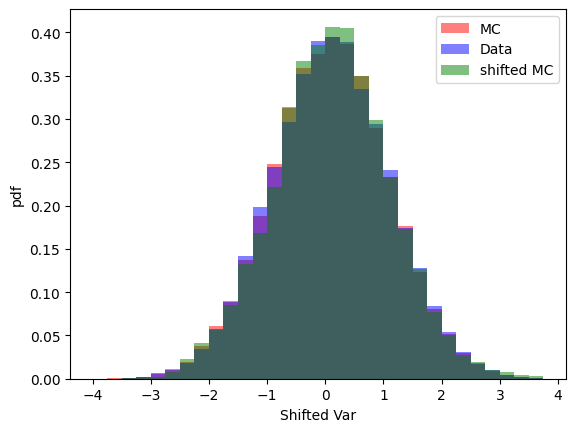

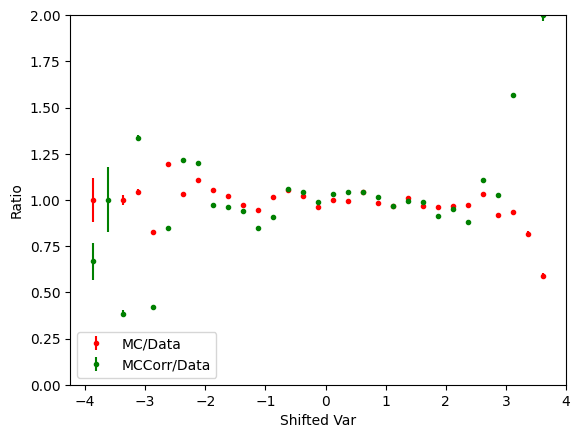

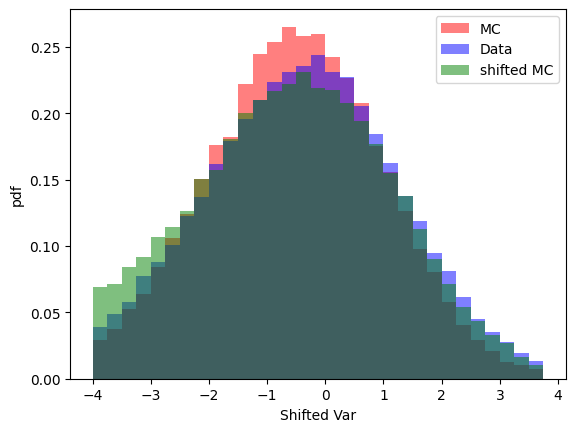

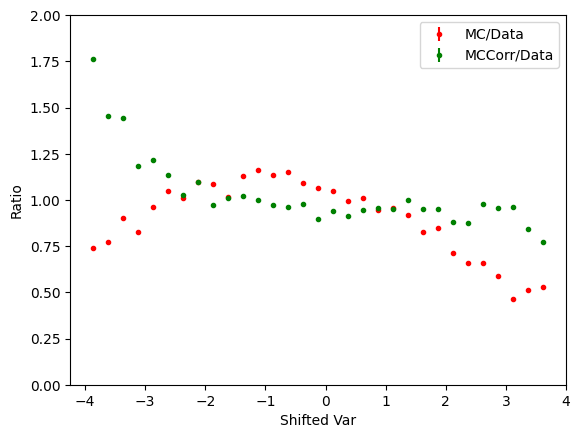

In [116]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test)
alldata_test2,test2_in,labeltest2_in=makeDataSet(iControl=False)
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,1]-data_train[:,3]-data_train[:,2]
mc_conserved=mc_train[:,1]-mc_train[:,3]-mc_train[:,2]
mccorr_conserved=mccorr_train['1']-mccorr_train['3']-mccorr_train['2']
quantileComp(data_conserved,mc_conserved,mccorr_conserved)

Need to clen up plots, but not looking perfect, not sure why